In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from scipy.interpolate import interp1d

In [3]:
N = 8192 #36864
dx = 3900 / 36864. #819.2 / N #3900. / N

In [10]:
def extract_an_vals(curr_dist, max_dist):
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    #path_an = "/home/abuzovkin/py_atm/scripts/an_data"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = [[float(m) for m in s.strip().split(" ")] for s in data if len(s) > 0]

    if np.max([n[0] for n in data]) < max_dist:
        data.append([max_dist + 1, 1e-10])
    interCurve = interp1d([n[0] for n in data], [n[1] for n in data], kind="linear")
    return interCurve

def take_half(curr_dist):
    # path to analytical curves
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = np.stack([np.array([float(m) for m in s.strip().split(" ")]) \
            for s in data if len(s) > 0])

    # half-width
    data = data[data[:,1] > 0.5 * data[0,1], 0][-1]
    return data

# for norming
def area(x, y):
    ans_area = 0.
    for i in range(len(y)):
        ans_area += y[i] * (x[i+1] - x[i])
    return ans_area

def calc_square(x, y):
    sum_curr = 0.
    for i in range(len(x)-1):
        sum_curr += (x[i + 1] - x[i]) * (y[i + 1] + y[i]) / 2
    return sum_curr

dists = [28, 56, 84, 112]
#dists = [3.5, 7.0, 14., 21., 28.] #[28, 56, 84, 112]
halfs = [take_half(d) for d in dists] #[127, 200, 350, 500]
db = {k: [] for k in dists}
db_x = {k: [] for k in dists}
db_an = {k: [] for k in dists}
storage_for_fit = {k: [] for k in dists}
num_max = 13

for d0,d in enumerate(dists):
    #if d0 > 1:
    #    break
    path_28_f = "/home/alex/TP/hse_data/36864_eq"
    #"/home/alex/TP/hse_data/dists_f"
    key_files = [k for k in os.listdir(path_28_f) if \
                 str(k[:2])==str(int(d)) or \
                 str(k[:3])==str(int(d)) or \
                 str(k[:2])==str(d) or \
                 str(k[:3])==str(d)]
    
    print(d, len(key_files), "curr_files")
    an_vals = extract_an_vals(d, 1500.)

    half_curr = take_half(d)
    rads = np.array([n * half_curr / 10 for n in range(num_max+1)])
    #rads = rads[rads < 819.2]

    for fp0,fp in enumerate(key_files):
        with open(os.path.join(path_28_f, fp), "rb") as f28b:
            data_new = pickle.load(f28b)        

        """
        rads = np.array([0, 25, 45, 79, 112, 138, 160, 179, 197, 213, 228, 243, 270, \
                300, 330, 360, 390, 420, 450, 480, 510, 540, \
                570, 600, 630, 660, 700, 750, 800, 850, 900, 950, \
                1000, 1050, 1100, 1150, 1200, 1250, 1300, 1400, \
                1500, 1600, 1700, 1800]) / dx
        rads = rads[::2]
        rads = rads[:19]
        """
        """
        if d0 == 0:
            rads = np.array([127 / 40. * n for n in \
                             range(int(1850 / (127 / 40.)))]) / dx
        else:
            rads = np.array([halfs[d0] / 40. * n for n in \
                         range(int(450 / (halfs[d0] / 40.)))]) / dx
        """
        for p in range(num_max):
            #len(data_new[1])):
            x = np.array(data_new[2][p])
            print(x)
            y = np.array(data_new[1][p]).ravel()
            # / calc_square(x, np.array(data_new[1][p]))
            #print(len(x), len(y))
            #ax[p].plot(x, y)
            #l_reg = LinearRegression()
            #print(x,y)
            #xfit, yfit = [x[y!=0]][:][0].reshape(-1, 1), np.log([y[y!=0]][:][0])
            #l_reg.fit(xfit[:int(len(xfit)*0.7)], yfit[:int(len(xfit)*0.7)])
            if fp0 == 0:
                db[d].append(y)#-1/l_reg.coef_[0])
                db_x[d].append(x)
                #storage_for_fit[d].append([xfit, yfit])
            else:
                #print(p)
                db[d][p] += y#1/l_reg.coef_[0]
        #print(fp0, d)

    #db[d] = np.array(db[d])
    #for p in range(len(data_new[1])):
    #    db[d][p] /= float(len(key_files))
    # db[d] /= len(key_files)
    
    # norming procedure
    #fig, ax = plt.subplots(len(data_new[1]), 1, figsize=(14, 70))
    for p in range(num_max):
        db_an[d].append(an_vals((rads[p] + rads[p+1]) / 2.))
        #data_new[1])):
        #print(db_x[d][p].shape, db[d][p].shape)
        print(np.sum(db[d][p]))#[1:]))
        db[d][p] = db[d][p].astype(float)
        #ax[p].set_title(str(d)+" km, log")
        #ax[p].bar((db_x[d][p][1:]+db_x[d][p][:1])/2, np.log(db[d][p]), width=(db_x[d][p][1]-db_x[d][p][0])*0.9)
        #db[d][p] /= area(db_x[d][p], db[d][p])
    #plt.savefig("/home/alex/TP/all_"+str(d)+".pdf")
    print("==============", len(key_files), d)
    print("-------", len(rads), len(data_new[1]), "0000000")


28 249 curr_files
[0.00000000e+00 1.09041273e-07 2.46316129e-07 4.19134969e-07
 6.36701042e-07 9.10600555e-07 1.25541968e-06 1.68952133e-06
 2.23602303e-06 2.92402805e-06 3.79017523e-06 4.88059013e-06
 6.25334145e-06 7.98153330e-06 1.01571984e-05 1.28961990e-05
 1.63443971e-05 2.06854223e-05 2.61504503e-05 3.30305142e-05
 4.16920033e-05 5.25961742e-05 6.63237148e-05 8.36056679e-05
 1.05362362e-04 1.32752423e-04 1.67234474e-04 2.10644812e-04
 2.65295201e-04 3.34095978e-04 4.20711042e-04 5.29752969e-04
 6.67028649e-04 8.39848526e-04 1.05741590e-03 1.33131706e-03
 1.67613826e-03 2.11024251e-03 2.65674749e-03 3.34475664e-03
 4.21090901e-03 5.30133046e-03 6.67409001e-03 8.40229223e-03
 1.05779704e-02 1.33169874e-02 1.67652062e-02 2.11062574e-02
 2.65713182e-02 3.34514234e-02 4.21129645e+03]
[0.00000000e+00 1.07612896e-07 2.43089532e-07 4.13644545e-07
 6.28360630e-07 8.98672218e-07 1.23897441e-06 1.66738958e-06
 2.20673243e-06 2.88572499e-06 3.74052614e-06 4.81665725e-06
 6.17142632e-06 7.87

[0.00000000e+00 5.46772891e-08 1.23511932e-07 2.10169629e-07
 3.19265229e-07 4.56608480e-07 6.29513423e-07 8.47187892e-07
 1.12122387e-06 1.46621479e-06 1.90053272e-06 2.44730670e-06
 3.13565450e-06 4.00223322e-06 5.09319140e-06 6.46662665e-06
 8.19567953e-06 1.03724286e-05 1.31127938e-05 1.65627100e-05
 2.09058979e-05 2.63736487e-05 3.32571405e-05 4.19229449e-05
 5.28325486e-05 6.65669285e-05 8.38574920e-05 1.05625026e-04
 1.33028733e-04 1.67527964e-04 2.10959930e-04 2.65637547e-04
 3.34472603e-04 4.21130821e-04 5.30227075e-04 6.67571149e-04
 8.40477130e-04 1.05815291e-03 1.33219053e-03 1.67718352e-03
 2.11150405e-03 2.65828132e-03 3.34663325e-03 4.21321716e-03
 5.30418189e-03 6.67762538e-03 8.40668864e-03 1.05834507e-02
 1.33238324e-02 1.67737693e-02 2.11169833e+03]
[0.00000000e+00 4.79273423e-08 1.08264304e-07 1.84224053e-07
 2.79851730e-07 4.00239867e-07 5.51799583e-07 7.42601998e-07
 9.82808055e-07 1.28520963e-06 1.66591072e-06 2.14518510e-06
 2.74855592e-06 3.50815493e-06 4.46443

 2.33510233e-02 2.93972983e-02 3.70091091e+03]
[0.00000000e+00 8.98839257e-08 2.03041106e-07 3.45497585e-07
 5.24839702e-07 7.50618096e-07 1.03485631e-06 1.39269109e-06
 1.84317848e-06 2.41030862e-06 3.12428331e-06 4.02312436e-06
 5.15469843e-06 6.57926607e-06 8.37269083e-06 1.06304793e-05
 1.34728671e-05 1.70512221e-05 2.15561050e-05 2.72274177e-05
 3.43671789e-05 4.33556074e-05 5.46713707e-05 6.89170756e-05
 8.68513590e-05 1.09429289e-04 1.37853224e-04 1.73636845e-04
 2.18685765e-04 2.75399005e-04 3.46796759e-04 4.36681224e-04
 5.49839084e-04 6.92296418e-04 8.71639611e-04 1.09741936e-03
 1.38165928e-03 1.73949621e-03 2.18998630e-03 2.75711984e-03
 3.47109881e-03 4.36994526e-03 5.50152612e-03 6.92610230e-03
 8.71953782e-03 1.09773398e-02 1.38197447e-02 1.73981212e-02
 2.19030311e-02 2.75743779e-02 3.47141818e+03]
[0.00000000e+00 8.32787408e-08 1.88120485e-07 3.20108447e-07
 4.86271480e-07 6.95458386e-07 9.58809151e-07 1.29034819e-06
 1.70773119e-06 2.23318536e-06 2.89469310e-06 3.7274

[0.00000000e+00 1.09041273e-07 2.46316129e-07 4.19134969e-07
 6.36701042e-07 9.10600555e-07 1.25541968e-06 1.68952133e-06
 2.23602303e-06 2.92402805e-06 3.79017523e-06 4.88059013e-06
 6.25334145e-06 7.98153330e-06 1.01571984e-05 1.28961990e-05
 1.63443971e-05 2.06854223e-05 2.61504503e-05 3.30305142e-05
 4.16920033e-05 5.25961742e-05 6.63237148e-05 8.36056679e-05
 1.05362362e-04 1.32752423e-04 1.67234474e-04 2.10644812e-04
 2.65295201e-04 3.34095978e-04 4.20711042e-04 5.29752969e-04
 6.67028649e-04 8.39848526e-04 1.05741590e-03 1.33131706e-03
 1.67613826e-03 2.11024251e-03 2.65674749e-03 3.34475664e-03
 4.21090901e-03 5.30133046e-03 6.67409001e-03 8.40229223e-03
 1.05779704e-02 1.33169874e-02 1.67652062e-02 2.11062574e-02
 2.65713182e-02 3.34514234e-02 4.21129645e+03]
[0.00000000e+00 1.07612896e-07 2.43089532e-07 4.13644545e-07
 6.28360630e-07 8.98672218e-07 1.23897441e-06 1.66738958e-06
 2.20673243e-06 2.88572499e-06 3.74052614e-06 4.81665725e-06
 6.17142632e-06 7.87697987e-06 1.00241

 1.01326334e-02 1.27562738e-02 1.60592420e+03]
[0.00000000e+00 1.09041273e-07 2.46316129e-07 4.19134969e-07
 6.36701042e-07 9.10600555e-07 1.25541968e-06 1.68952133e-06
 2.23602303e-06 2.92402805e-06 3.79017523e-06 4.88059013e-06
 6.25334145e-06 7.98153330e-06 1.01571984e-05 1.28961990e-05
 1.63443971e-05 2.06854223e-05 2.61504503e-05 3.30305142e-05
 4.16920033e-05 5.25961742e-05 6.63237148e-05 8.36056679e-05
 1.05362362e-04 1.32752423e-04 1.67234474e-04 2.10644812e-04
 2.65295201e-04 3.34095978e-04 4.20711042e-04 5.29752969e-04
 6.67028649e-04 8.39848526e-04 1.05741590e-03 1.33131706e-03
 1.67613826e-03 2.11024251e-03 2.65674749e-03 3.34475664e-03
 4.21090901e-03 5.30133046e-03 6.67409001e-03 8.40229223e-03
 1.05779704e-02 1.33169874e-02 1.67652062e-02 2.11062574e-02
 2.65713182e-02 3.34514234e-02 4.21129645e+03]
[0.00000000e+00 1.07612896e-07 2.43089532e-07 4.13644545e-07
 6.28360630e-07 8.98672218e-07 1.23897441e-06 1.66738958e-06
 2.20673243e-06 2.88572499e-06 3.74052614e-06 4.8166

 2.62232494e-02 3.30132293e-02 4.15613092e+03]
[0.00000000e+00 1.04916878e-07 2.36999429e-07 4.03281541e-07
 6.12618360e-07 8.76157854e-07 1.20793449e-06 1.62561660e-06
 2.15144734e-06 2.81342915e-06 3.64681503e-06 4.69598591e-06
 6.01681406e-06 7.67963851e-06 9.77301089e-06 1.24084111e-05
 1.57261840e-05 1.99030136e-05 2.51613314e-05 3.17811628e-05
 4.01150383e-05 5.06067681e-05 6.38150760e-05 8.04433537e-05
 1.01377119e-04 1.27731174e-04 1.60908970e-04 2.02677349e-04
 2.55260633e-04 3.21459078e-04 4.04798000e-04 5.09715508e-04
 6.41798851e-04 8.08081961e-04 1.01742004e-03 1.28096111e-03
 1.61273973e-03 2.03042436e-03 2.55625825e-03 3.21824403e-03
 4.05163491e-03 5.10081209e-03 6.42164816e-03 8.08448259e-03
 1.01778675e-02 1.28132835e-02 1.61310764e-02 2.03079310e-02
 2.55662804e-02 3.21861514e-02 4.05200770e+03]
[0.00000000e+00 1.00871184e-07 2.27860506e-07 3.87730623e-07
 5.88995216e-07 8.42372376e-07 1.16135539e-06 1.56293129e-06
 2.06848549e-06 2.70494065e-06 3.50619039e-06 4.5149

 1.01326334e-02 1.27562738e-02 1.60592420e+03]
[0.00000000e+00 1.09041273e-07 2.46316129e-07 4.19134969e-07
 6.36701042e-07 9.10600555e-07 1.25541968e-06 1.68952133e-06
 2.23602303e-06 2.92402805e-06 3.79017523e-06 4.88059013e-06
 6.25334145e-06 7.98153330e-06 1.01571984e-05 1.28961990e-05
 1.63443971e-05 2.06854223e-05 2.61504503e-05 3.30305142e-05
 4.16920033e-05 5.25961742e-05 6.63237148e-05 8.36056679e-05
 1.05362362e-04 1.32752423e-04 1.67234474e-04 2.10644812e-04
 2.65295201e-04 3.34095978e-04 4.20711042e-04 5.29752969e-04
 6.67028649e-04 8.39848526e-04 1.05741590e-03 1.33131706e-03
 1.67613826e-03 2.11024251e-03 2.65674749e-03 3.34475664e-03
 4.21090901e-03 5.30133046e-03 6.67409001e-03 8.40229223e-03
 1.05779704e-02 1.33169874e-02 1.67652062e-02 2.11062574e-02
 2.65713182e-02 3.34514234e-02 4.21129645e+03]
[0.00000000e+00 1.07612896e-07 2.43089532e-07 4.13644545e-07
 6.28360630e-07 8.98672218e-07 1.23897441e-06 1.66738958e-06
 2.20673243e-06 2.88572499e-06 3.74052614e-06 4.8166

[0.00000000e+00 1.09041273e-07 2.46316129e-07 4.19134969e-07
 6.36701042e-07 9.10600555e-07 1.25541968e-06 1.68952133e-06
 2.23602303e-06 2.92402805e-06 3.79017523e-06 4.88059013e-06
 6.25334145e-06 7.98153330e-06 1.01571984e-05 1.28961990e-05
 1.63443971e-05 2.06854223e-05 2.61504503e-05 3.30305142e-05
 4.16920033e-05 5.25961742e-05 6.63237148e-05 8.36056679e-05
 1.05362362e-04 1.32752423e-04 1.67234474e-04 2.10644812e-04
 2.65295201e-04 3.34095978e-04 4.20711042e-04 5.29752969e-04
 6.67028649e-04 8.39848526e-04 1.05741590e-03 1.33131706e-03
 1.67613826e-03 2.11024251e-03 2.65674749e-03 3.34475664e-03
 4.21090901e-03 5.30133046e-03 6.67409001e-03 8.40229223e-03
 1.05779704e-02 1.33169874e-02 1.67652062e-02 2.11062574e-02
 2.65713182e-02 3.34514234e-02 4.21129645e+03]
[0.00000000e+00 1.07612896e-07 2.43089532e-07 4.13644545e-07
 6.28360630e-07 8.98672218e-07 1.23897441e-06 1.66738958e-06
 2.20673243e-06 2.88572499e-06 3.74052614e-06 4.81665725e-06
 6.17142632e-06 7.87697987e-06 1.00241

 2.45804204e-02 3.09450229e-02 3.89575844e+03]
[0.00000000e+00 9.58260813e-08 2.16463994e-07 3.68338159e-07
 5.59536442e-07 8.00240868e-07 1.10326985e-06 1.48476081e-06
 1.96502956e-06 2.56965223e-06 3.33082722e-06 4.28908995e-06
 5.49547149e-06 7.01421617e-06 8.92620283e-06 1.13332519e-05
 1.43635478e-05 1.81784650e-05 2.29811622e-05 2.90274009e-05
 3.66391660e-05 4.62218125e-05 5.82856520e-05 7.34731292e-05
 9.25930341e-05 1.16663573e-04 1.46966592e-04 1.85115840e-04
 2.33142908e-04 2.93605417e-04 3.69723220e-04 4.65549876e-04
 5.86188513e-04 7.38063589e-04 9.29263020e-04 1.16996889e-03
 1.47299969e-03 1.85449293e-03 2.33476457e-03 2.93939087e-03
 3.70057042e-03 4.65883890e-03 5.86522768e-03 7.38398148e-03
 9.29597961e-03 1.17030431e-02 1.47333572e-02 1.85482973e-02
 2.33510233e-02 2.93972983e-02 3.70091091e+03]
[0.00000000e+00 8.98839257e-08 2.03041106e-07 3.45497585e-07
 5.24839702e-07 7.50618096e-07 1.03485631e-06 1.39269109e-06
 1.84317848e-06 2.41030862e-06 3.12428331e-06 4.0231

[0.00000000e+00 5.46772891e-08 1.23511932e-07 2.10169629e-07
 3.19265229e-07 4.56608480e-07 6.29513423e-07 8.47187892e-07
 1.12122387e-06 1.46621479e-06 1.90053272e-06 2.44730670e-06
 3.13565450e-06 4.00223322e-06 5.09319140e-06 6.46662665e-06
 8.19567953e-06 1.03724286e-05 1.31127938e-05 1.65627100e-05
 2.09058979e-05 2.63736487e-05 3.32571405e-05 4.19229449e-05
 5.28325486e-05 6.65669285e-05 8.38574920e-05 1.05625026e-04
 1.33028733e-04 1.67527964e-04 2.10959930e-04 2.65637547e-04
 3.34472603e-04 4.21130821e-04 5.30227075e-04 6.67571149e-04
 8.40477130e-04 1.05815291e-03 1.33219053e-03 1.67718352e-03
 2.11150405e-03 2.65828132e-03 3.34663325e-03 4.21321716e-03
 5.30418189e-03 6.67762538e-03 8.40668864e-03 1.05834507e-02
 1.33238324e-02 1.67737693e-02 2.11169833e+03]
[0.00000000e+00 4.79273423e-08 1.08264304e-07 1.84224053e-07
 2.79851730e-07 4.00239867e-07 5.51799583e-07 7.42601998e-07
 9.82808055e-07 1.28520963e-06 1.66591072e-06 2.14518510e-06
 2.74855592e-06 3.50815493e-06 4.46443

[0.00000000e+00 1.09041273e-07 2.46316129e-07 4.19134969e-07
 6.36701042e-07 9.10600555e-07 1.25541968e-06 1.68952133e-06
 2.23602303e-06 2.92402805e-06 3.79017523e-06 4.88059013e-06
 6.25334145e-06 7.98153330e-06 1.01571984e-05 1.28961990e-05
 1.63443971e-05 2.06854223e-05 2.61504503e-05 3.30305142e-05
 4.16920033e-05 5.25961742e-05 6.63237148e-05 8.36056679e-05
 1.05362362e-04 1.32752423e-04 1.67234474e-04 2.10644812e-04
 2.65295201e-04 3.34095978e-04 4.20711042e-04 5.29752969e-04
 6.67028649e-04 8.39848526e-04 1.05741590e-03 1.33131706e-03
 1.67613826e-03 2.11024251e-03 2.65674749e-03 3.34475664e-03
 4.21090901e-03 5.30133046e-03 6.67409001e-03 8.40229223e-03
 1.05779704e-02 1.33169874e-02 1.67652062e-02 2.11062574e-02
 2.65713182e-02 3.34514234e-02 4.21129645e+03]
[0.00000000e+00 1.07612896e-07 2.43089532e-07 4.13644545e-07
 6.28360630e-07 8.98672218e-07 1.23897441e-06 1.66738958e-06
 2.20673243e-06 2.88572499e-06 3.74052614e-06 4.81665725e-06
 6.17142632e-06 7.87697987e-06 1.00241

[0.00000000e+00 6.17117712e-09 1.39402304e-08 2.37208909e-08
 3.60340154e-08 5.15353239e-08 7.10503190e-08 9.56182471e-08
 1.26547442e-07 1.65485000e-07 2.14504490e-07 2.76216385e-07
 3.53907073e-07 4.51713874e-07 5.74845366e-07 7.29858761e-07
 9.25009102e-07 1.17068887e-06 1.47998144e-06 1.86935780e-06
 2.35955369e-06 2.97667387e-06 3.75358230e-06 4.73165226e-06
 5.96296964e-06 7.51310669e-06 9.46461401e-06 1.19214166e-05
 1.50143485e-05 1.89081199e-05 2.38100885e-05 2.99813027e-05
 3.77504026e-05 4.75311218e-05 5.98443202e-05 7.53457217e-05
 9.48608338e-05 1.19428909e-04 1.50358290e-04 1.89296081e-04
 2.38315866e-04 3.00028131e-04 3.77719285e-04 4.75526673e-04
 5.98658903e-04 7.53673228e-04 9.48824740e-04 1.19450599e-03
 1.50380041e-03 1.89317910e-03 2.38337793e+02]
[0.00000000e+00 1.25164015e-08 2.82736205e-08 4.81107879e-08
 7.30843070e-08 1.04524111e-07 1.44104488e-07 1.93933239e-07
 2.56663933e-07 3.35637214e-07 4.35058704e-07 5.60222969e-07
 7.17795474e-07 9.16167545e-07 1.16590

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[0.00000000e+00 7.56398305e-09 1.70864754e-08 2.90745855e-08
 4.41667249e-08 6.31666065e-08 8.70860450e-08 1.17198840e-07
 1.55108611e-07 2.02834193e-07 2.62917155e-07 3.38557136e-07
 4.33782251e-07 5.53663591e-07 7.04585287e-07 8.94584483e-07
 1.13377935e-06 1.43490790e-06 1.81400636e-06 2.29126315e-06
 2.89209396e-06 3.64849529e-06 4.60074834e-06 5.79956414e-06
 7.30878411e-06 9.20877987e-06 1.16007333e-05 1.46120248e-05
 1.84030171e-05 2.31755944e-05 2.91839146e-05 3.67479430e-05
 4.62704925e-05 5.82586745e-05 7.33509045e-05 9.23509001e-05
 1.16270482e-04 1.46383458e-04 1.84293456e-04 2.32019325e-04
 2.92102647e-04 3.67743082e-04 4.62968768e-04 5.82850828e-04
 7.33773429e-04 9.23773765e-04 1.16297006e-03 1.46410042e-03
 1.84320116e-03 2.32046081e-03 2.92129523e+02]
[0.00000000e+00 6.86758009e-09 1.55133529e-08 2.63977382e-08
 4.01003702e-08 5.73509652e-08 7.90681820e-08 1.06408544e-07
 1.40828026e-07 1.84159597e-07 2.38710823e-07 3.07386761e-07
 3.93844662e-07 5.02688732e-07 6.3971

 2.01267925e-03 2.53382182e-03 3.18990158e+02]
[0.00000000e+00 7.56398305e-09 1.70864754e-08 2.90745855e-08
 4.41667249e-08 6.31666065e-08 8.70860450e-08 1.17198840e-07
 1.55108611e-07 2.02834193e-07 2.62917155e-07 3.38557136e-07
 4.33782251e-07 5.53663591e-07 7.04585287e-07 8.94584483e-07
 1.13377935e-06 1.43490790e-06 1.81400636e-06 2.29126315e-06
 2.89209396e-06 3.64849529e-06 4.60074834e-06 5.79956414e-06
 7.30878411e-06 9.20877987e-06 1.16007333e-05 1.46120248e-05
 1.84030171e-05 2.31755944e-05 2.91839146e-05 3.67479430e-05
 4.62704925e-05 5.82586745e-05 7.33509045e-05 9.23509001e-05
 1.16270482e-04 1.46383458e-04 1.84293456e-04 2.32019325e-04
 2.92102647e-04 3.67743082e-04 4.62968768e-04 5.82850828e-04
 7.33773429e-04 9.23773765e-04 1.16297006e-03 1.46410042e-03
 1.84320116e-03 2.32046081e-03 2.92129523e+02]
[0.00000000e+00 6.86758009e-09 1.55133529e-08 2.63977382e-08
 4.01003702e-08 5.73509652e-08 7.90681820e-08 1.06408544e-07
 1.40828026e-07 1.84159597e-07 2.38710823e-07 3.0738

[0.00000000e+00 1.25164015e-08 2.82736205e-08 4.81107879e-08
 7.30843070e-08 1.04524111e-07 1.44104488e-07 1.93933239e-07
 2.56663933e-07 3.35637214e-07 4.35058704e-07 5.60222969e-07
 7.17795474e-07 9.16167545e-07 1.16590324e-06 1.48030191e-06
 1.87610646e-06 2.37439497e-06 3.00170317e-06 3.79143755e-06
 4.78565444e-06 6.03729959e-06 7.61302780e-06 9.59675247e-06
 1.20941144e-05 1.52381074e-05 1.91961608e-05 2.41790559e-05
 3.04521504e-05 3.83495101e-05 4.82916988e-05 6.08081754e-05
 7.65654890e-05 9.64027754e-05 1.21376444e-04 1.52816437e-04
 1.92397051e-04 2.42226101e-04 3.04957172e-04 3.83930926e-04
 4.83353013e-04 6.08518029e-04 7.66091480e-04 9.64464741e-04
 1.21420193e-03 1.52860249e-03 1.92440942e-03 2.42270092e-03
 3.05001288e-03 3.83975200e-03 4.83397485e+02]
[0.00000000e+00 1.23990872e-08 2.80086164e-08 4.76598532e-08
 7.23992995e-08 1.03544423e-07 1.42753819e-07 1.92115534e-07
 2.54258263e-07 3.32491340e-07 4.30980968e-07 5.54972088e-07
 7.11067692e-07 9.07580453e-07 1.15497

[0.00000000e+00 1.25164015e-08 2.82736205e-08 4.81107879e-08
 7.30843070e-08 1.04524111e-07 1.44104488e-07 1.93933239e-07
 2.56663933e-07 3.35637214e-07 4.35058704e-07 5.60222969e-07
 7.17795474e-07 9.16167545e-07 1.16590324e-06 1.48030191e-06
 1.87610646e-06 2.37439497e-06 3.00170317e-06 3.79143755e-06
 4.78565444e-06 6.03729959e-06 7.61302780e-06 9.59675247e-06
 1.20941144e-05 1.52381074e-05 1.91961608e-05 2.41790559e-05
 3.04521504e-05 3.83495101e-05 4.82916988e-05 6.08081754e-05
 7.65654890e-05 9.64027754e-05 1.21376444e-04 1.52816437e-04
 1.92397051e-04 2.42226101e-04 3.04957172e-04 3.83930926e-04
 4.83353013e-04 6.08518029e-04 7.66091480e-04 9.64464741e-04
 1.21420193e-03 1.52860249e-03 1.92440942e-03 2.42270092e-03
 3.05001288e-03 3.83975200e-03 4.83397485e+02]
[0.00000000e+00 1.23990872e-08 2.80086164e-08 4.76598532e-08
 7.23992995e-08 1.03544423e-07 1.42753819e-07 1.92115534e-07
 2.54258263e-07 3.32491340e-07 4.30980968e-07 5.54972088e-07
 7.11067692e-07 9.07580453e-07 1.15497

 4.86325978e-04 6.12250250e-04 7.70779548e+01]
[0.00000000e+00 1.77313951e-09 4.00539035e-09 6.81562822e-09
 1.03535088e-08 1.48074374e-08 2.04146025e-08 2.74736065e-08
 3.63603678e-08 4.75481397e-08 6.16327129e-08 7.93641434e-08
 1.01686696e-07 1.29789131e-07 1.65168008e-07 2.09707383e-07
 2.65779146e-07 3.36369328e-07 4.25237118e-07 5.37115061e-07
 6.77961074e-07 8.55275735e-07 1.07850171e-06 1.35952662e-06
 1.71331609e-06 2.15871074e-06 2.71942949e-06 3.42533272e-06
 4.31401240e-06 5.43279407e-06 6.84125701e-06 8.61440716e-06
 1.08466714e-05 1.36569261e-05 1.71948279e-05 2.16487833e-05
 2.72559820e-05 3.43150284e-05 4.32018430e-05 5.43896820e-05
 6.84743397e-05 8.62058766e-05 1.08528564e-04 1.36631167e-04
 1.72010256e-04 2.16549899e-04 2.72621998e-04 3.43212603e-04
 4.32080927e-04 5.43959541e-04 6.84806399e+01]
[0.00000000e+00 1.55988848e-09 3.52367213e-09 5.99592975e-09
 9.10831833e-09 1.30265842e-08 1.79593896e-08 2.41694250e-08
 3.19873978e-08 4.18296445e-08 5.42203015e-08 6.9819

[0.00000000e+00 3.47038161e-09 7.83933407e-09 1.33395205e-08
 2.02638463e-08 2.89810577e-08 3.99553789e-08 5.37712335e-08
 7.11643674e-08 9.30610301e-08 1.20627301e-07 1.55331186e-07
 1.99020798e-07 2.54022772e-07 3.23266168e-07 4.10438457e-07
 5.20181889e-07 6.58340711e-07 8.32272398e-07 1.05123946e-06
 1.32690272e-06 1.67394227e-06 2.11083926e-06 2.66086010e-06
 3.35329545e-06 4.22502008e-06 5.32245659e-06 6.70404758e-06
 8.44336793e-06 1.06330430e-05 1.33896810e-05 1.68600835e-05
 2.12290621e-05 2.67292815e-05 3.36536489e-05 4.23709126e-05
 5.33452997e-05 6.71612372e-05 8.45544754e-05 1.06451269e-04
 1.34017705e-04 1.68721799e-04 2.12411673e-04 2.67413977e-04
 3.36657789e-04 4.23830601e-04 5.33574691e-04 6.71734342e-04
 8.45667073e-04 1.06463545e-03 1.34030036e+02]
[0.00000000e+00 3.42846166e-09 7.74464003e-09 1.31783877e-08
 2.00190722e-08 2.86309854e-08 3.94727440e-08 5.31217120e-08
 7.03047482e-08 9.19369135e-08 1.19170201e-07 1.53454887e-07
 1.96616757e-07 2.50954342e-07 3.19361

[0.00000000e+00 3.47038161e-09 7.83933407e-09 1.33395205e-08
 2.02638463e-08 2.89810577e-08 3.99553789e-08 5.37712335e-08
 7.11643674e-08 9.30610301e-08 1.20627301e-07 1.55331186e-07
 1.99020798e-07 2.54022772e-07 3.23266168e-07 4.10438457e-07
 5.20181889e-07 6.58340711e-07 8.32272398e-07 1.05123946e-06
 1.32690272e-06 1.67394227e-06 2.11083926e-06 2.66086010e-06
 3.35329545e-06 4.22502008e-06 5.32245659e-06 6.70404758e-06
 8.44336793e-06 1.06330430e-05 1.33896810e-05 1.68600835e-05
 2.12290621e-05 2.67292815e-05 3.36536489e-05 4.23709126e-05
 5.33452997e-05 6.71612372e-05 8.45544754e-05 1.06451269e-04
 1.34017705e-04 1.68721799e-04 2.12411673e-04 2.67413977e-04
 3.36657789e-04 4.23830601e-04 5.33574691e-04 6.71734342e-04
 8.45667073e-04 1.06463545e-03 1.34030036e+02]
[0.00000000e+00 3.42846166e-09 7.74464003e-09 1.31783877e-08
 2.00190722e-08 2.86309854e-08 3.94727440e-08 5.31217120e-08
 7.03047482e-08 9.19369135e-08 1.19170201e-07 1.53454887e-07
 1.96616757e-07 2.50954342e-07 3.19361

 5.41748459e-04 6.82023261e-04 8.58618810e+01]
[0.00000000e+00 1.99574606e-09 4.50824199e-09 7.67128760e-09
 1.16533269e-08 1.66664183e-08 2.29775278e-08 3.09227455e-08
 4.09251840e-08 5.35175105e-08 6.93703135e-08 8.93278140e-08
 1.14452824e-07 1.46083343e-07 1.85903815e-07 2.36034830e-07
 2.99146051e-07 3.78598387e-07 4.78622972e-07 6.04546489e-07
 7.63074835e-07 9.62650240e-07 1.21390084e-06 1.53020666e-06
 1.92841219e-06 2.42972334e-06 3.06083681e-06 3.85536176e-06
 4.85560961e-06 6.11484729e-06 7.70013393e-06 9.69589196e-06
 1.22084030e-05 1.53714676e-05 1.93535307e-05 2.43666523e-05
 3.06777996e-05 3.86230650e-05 4.86255635e-05 6.12179655e-05
 7.70708636e-05 9.70284839e-05 1.22153644e-04 1.53784353e-04
 1.93605065e-04 2.43736380e-04 3.06847980e-04 3.86300793e-04
 4.86325978e-04 6.12250250e-04 7.70779548e+01]
[0.00000000e+00 1.77313951e-09 4.00539035e-09 6.81562822e-09
 1.03535088e-08 1.48074374e-08 2.04146025e-08 2.74736065e-08
 3.63603678e-08 4.75481397e-08 6.16327129e-08 7.9364

 5.41748459e-04 6.82023261e-04 8.58618810e+01]
[0.00000000e+00 1.99574606e-09 4.50824199e-09 7.67128760e-09
 1.16533269e-08 1.66664183e-08 2.29775278e-08 3.09227455e-08
 4.09251840e-08 5.35175105e-08 6.93703135e-08 8.93278140e-08
 1.14452824e-07 1.46083343e-07 1.85903815e-07 2.36034830e-07
 2.99146051e-07 3.78598387e-07 4.78622972e-07 6.04546489e-07
 7.63074835e-07 9.62650240e-07 1.21390084e-06 1.53020666e-06
 1.92841219e-06 2.42972334e-06 3.06083681e-06 3.85536176e-06
 4.85560961e-06 6.11484729e-06 7.70013393e-06 9.69589196e-06
 1.22084030e-05 1.53714676e-05 1.93535307e-05 2.43666523e-05
 3.06777996e-05 3.86230650e-05 4.86255635e-05 6.12179655e-05
 7.70708636e-05 9.70284839e-05 1.22153644e-04 1.53784353e-04
 1.93605065e-04 2.43736380e-04 3.06847980e-04 3.86300793e-04
 4.86325978e-04 6.12250250e-04 7.70779548e+01]
[0.00000000e+00 1.77313951e-09 4.00539035e-09 6.81562822e-09
 1.03535088e-08 1.48074374e-08 2.04146025e-08 2.74736065e-08
 3.63603678e-08 4.75481397e-08 6.16327129e-08 7.9364

 8.35451966e-04 1.05177535e-03 1.32411041e+02]
[0.00000000e+00 3.34210232e-09 7.54956069e-09 1.28464380e-08
 1.95148128e-08 2.79098010e-08 3.84784671e-08 5.17836320e-08
 6.85338456e-08 8.96211194e-08 1.16168429e-07 1.49589519e-07
 1.91664187e-07 2.44633067e-07 3.11316948e-07 3.95266998e-07
 5.00953870e-07 6.34005785e-07 8.01508256e-07 1.01238142e-06
 1.27785505e-06 1.61206662e-06 2.03281414e-06 2.56250399e-06
 3.22934414e-06 4.06884631e-06 5.12571715e-06 6.45623896e-06
 8.13126702e-06 1.02400028e-05 1.28947445e-05 1.62368668e-05
 2.04443505e-05 2.57412596e-05 3.24096744e-05 4.08047129e-05
 5.13734424e-05 6.46786872e-05 8.14290013e-05 1.02516402e-04
 1.29063871e-04 1.62485161e-04 2.04560082e-04 2.57529279e-04
 3.24213560e-04 4.08164114e-04 5.13851620e-04 6.46904334e-04
 8.14407810e-04 1.02528223e-03 1.29075746e+02]
[0.00000000e+00 3.21889684e-09 7.27124867e-09 1.23728584e-08
 1.87954058e-08 2.68809156e-08 3.70599713e-08 4.98746458e-08
 6.60073684e-08 8.63172669e-08 1.11885919e-07 1.4407

 8.35451966e-04 1.05177535e-03 1.32411041e+02]
[0.00000000e+00 3.34210232e-09 7.54956069e-09 1.28464380e-08
 1.95148128e-08 2.79098010e-08 3.84784671e-08 5.17836320e-08
 6.85338456e-08 8.96211194e-08 1.16168429e-07 1.49589519e-07
 1.91664187e-07 2.44633067e-07 3.11316948e-07 3.95266998e-07
 5.00953870e-07 6.34005785e-07 8.01508256e-07 1.01238142e-06
 1.27785505e-06 1.61206662e-06 2.03281414e-06 2.56250399e-06
 3.22934414e-06 4.06884631e-06 5.12571715e-06 6.45623896e-06
 8.13126702e-06 1.02400028e-05 1.28947445e-05 1.62368668e-05
 2.04443505e-05 2.57412596e-05 3.24096744e-05 4.08047129e-05
 5.13734424e-05 6.46786872e-05 8.14290013e-05 1.02516402e-04
 1.29063871e-04 1.62485161e-04 2.04560082e-04 2.57529279e-04
 3.24213560e-04 4.08164114e-04 5.13851620e-04 6.46904334e-04
 8.14407810e-04 1.02528223e-03 1.29075746e+02]
[0.00000000e+00 3.21889684e-09 7.27124867e-09 1.23728584e-08
 1.87954058e-08 2.68809156e-08 3.70599713e-08 4.98746458e-08
 6.60073684e-08 8.63172669e-08 1.11885919e-07 1.4407

 5.41748459e-04 6.82023261e-04 8.58618810e+01]
[0.00000000e+00 1.99574606e-09 4.50824199e-09 7.67128760e-09
 1.16533269e-08 1.66664183e-08 2.29775278e-08 3.09227455e-08
 4.09251840e-08 5.35175105e-08 6.93703135e-08 8.93278140e-08
 1.14452824e-07 1.46083343e-07 1.85903815e-07 2.36034830e-07
 2.99146051e-07 3.78598387e-07 4.78622972e-07 6.04546489e-07
 7.63074835e-07 9.62650240e-07 1.21390084e-06 1.53020666e-06
 1.92841219e-06 2.42972334e-06 3.06083681e-06 3.85536176e-06
 4.85560961e-06 6.11484729e-06 7.70013393e-06 9.69589196e-06
 1.22084030e-05 1.53714676e-05 1.93535307e-05 2.43666523e-05
 3.06777996e-05 3.86230650e-05 4.86255635e-05 6.12179655e-05
 7.70708636e-05 9.70284839e-05 1.22153644e-04 1.53784353e-04
 1.93605065e-04 2.43736380e-04 3.06847980e-04 3.86300793e-04
 4.86325978e-04 6.12250250e-04 7.70779548e+01]
[0.00000000e+00 1.77313951e-09 4.00539035e-09 6.81562822e-09
 1.03535088e-08 1.48074374e-08 2.04146025e-08 2.74736065e-08
 3.63603678e-08 4.75481397e-08 6.16327129e-08 7.9364

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[0.00000000e+00 9.22945312e-10 2.08486485e-09 3.54763518e-09
 5.38915428e-09 7.70748995e-09 1.06261022e-08 1.43004181e-08
 1.89261086e-08 2.47495092e-08 3.20807376e-08 4.13102092e-08
 5.29294278e-08 6.75571603e-08 8.59723882e-08 1.09155791e-07
 1.38341972e-07 1.75085204e-07 2.21342203e-07 2.79576324e-07
 3.52888755e-07 4.45183656e-07 5.61376074e-07 7.07653692e-07
 8.91806339e-07 1.12364083e-06 1.41550323e-06 1.78293628e-06
 2.24550719e-06 2.82784957e-06 3.56097535e-06 4.48392620e-06
 5.64585271e-06 7.10863181e-06 8.95016197e-06 1.12685115e-05
 1.41871413e-05 1.78614792e-05 2.24871975e-05 2.83106330e-05
 3.56419054e-05 4.48714324e-05 5.64907207e-05 7.11185410e-05
 8.95338794e-05 1.12717421e-04 1.41903778e-04 1.78647230e-04
 2.24904506e-04 2.83138977e-04 3.56451848e+01]
[0.00000000e+00 8.35161080e-10 1.88656680e-09 3.21020844e-09
 4.87657487e-09 6.97440633e-09 9.61542020e-09 1.29402603e-08
 1.71259869e-08 2.23955055e-08 2.90294377e-08 3.73810652e-08
 4.78951434e-08 6.11315863e-08 7.7795

[0.00000000e+00 1.38882343e-09 3.13724889e-09 5.33838656e-09
 8.10945528e-09 1.15980248e-08 1.59898745e-08 2.15188868e-08
 2.84795023e-08 3.72423997e-08 4.82742362e-08 6.21624983e-08
 7.96467878e-08 1.01658209e-07 1.29368951e-07 1.64254716e-07
 2.08173301e-07 2.63463534e-07 3.33069828e-07 4.20698978e-07
 5.31017564e-07 6.69900462e-07 8.44743707e-07 1.06485836e-06
 1.34196634e-06 1.69082468e-06 2.13001141e-06 2.68291485e-06
 3.37897918e-06 4.25527243e-06 5.35846049e-06 6.74729225e-06
 8.49572820e-06 1.06968791e-05 1.34679644e-05 1.69565549e-05
 2.13484309e-05 2.68774764e-05 3.38381336e-05 4.26010836e-05
 5.36329863e-05 6.75213317e-05 8.50057262e-05 1.07017279e-04
 1.34728188e-04 1.69614162e-04 2.13533010e-04 2.68823576e-04
 3.38430287e-04 4.26059963e-04 5.36379210e+01]
[0.00000000e+00 1.37264767e-09 3.10070906e-09 5.27620988e-09
 8.01500370e-09 1.14629415e-08 1.58036389e-08 2.12682543e-08
 2.81477989e-08 3.68086340e-08 4.77119817e-08 6.14384859e-08
 7.87191343e-08 1.00474186e-07 1.27862

 2.85000424e-04 3.58795518e-04 4.51698055e+01]
[0.00000000e+00 1.09194708e-09 2.46662727e-09 4.19724745e-09
 6.37596961e-09 9.11881885e-09 1.25718622e-08 1.69189870e-08
 2.23916940e-08 2.92814253e-08 3.79550848e-08 4.88745774e-08
 6.26214069e-08 7.99276433e-08 1.01714908e-07 1.29143456e-07
 1.63673958e-07 2.07145293e-07 2.61872472e-07 3.30769923e-07
 4.17506692e-07 5.26701837e-07 6.64170406e-07 8.37233117e-07
 1.05510620e-06 1.32939222e-06 1.67469794e-06 2.10941216e-06
 2.65668505e-06 3.34566093e-06 4.21303036e-06 5.30498399e-06
 6.67967243e-06 8.41030299e-06 1.05890382e-05 1.33319039e-05
 1.67849679e-05 2.11321188e-05 2.66048587e-05 3.34946313e-05
 4.21683429e-05 5.30879010e-05 6.68348130e-05 8.41411532e-05
 1.05928549e-04 1.33357261e-04 1.67887970e-04 2.11359566e-04
 2.66087074e-04 3.34984938e-04 4.21722228e+01]
[0.00000000e+00 1.00854064e-09 2.27821834e-09 3.87664818e-09
 5.88895253e-09 8.42229412e-09 1.16115829e-08 1.56266603e-08
 2.06813443e-08 2.70448158e-08 3.50559533e-08 4.5141

 3.34488558e-04 4.21097603e-04 5.30131952e+01]
[0.00000000e+00 1.34414345e-09 3.03632014e-09 5.16664481e-09
 7.84856519e-09 1.12249036e-08 1.54754627e-08 2.08266006e-08
 2.75632854e-08 3.60442708e-08 4.67212010e-08 6.01626624e-08
 7.70844631e-08 9.83877524e-08 1.25207010e-07 1.58970461e-07
 2.01476137e-07 2.54987623e-07 3.22354606e-07 4.07164630e-07
 5.13934145e-07 6.48349028e-07 8.17567374e-07 1.03060069e-06
 1.29879380e-06 1.63642900e-06 2.06148660e-06 2.59660253e-06
 3.27027371e-06 4.11837564e-06 5.18607293e-06 6.53022445e-06
 8.22241129e-06 1.03527487e-05 1.30346852e-05 1.64110439e-05
 2.06616284e-05 2.60127984e-05 3.27495237e-05 4.12305600e-05
 5.19075542e-05 6.53490963e-05 8.22709986e-05 1.03574416e-04
 1.30393834e-04 1.64157488e-04 2.06663419e-04 2.60175226e-04
 3.27542613e-04 4.12353146e-04 5.19123302e+01]
[0.00000000e+00 1.29629295e-09 2.92822942e-09 4.98271611e-09
 7.56916214e-09 1.08253054e-08 1.49245478e-08 2.00851892e-08
 2.65820530e-08 3.47611217e-08 4.50579612e-08 5.8020

 3.15882341e-04 3.97673682e-04 5.00642900e+01]
[0.00000000e+00 1.24138597e-09 2.80419863e-09 4.77166360e-09
 7.24855574e-09 1.03667788e-08 1.42923899e-08 1.92344424e-08
 2.54561191e-08 3.32887476e-08 4.31494447e-08 5.55633292e-08
 7.11914871e-08 9.08661761e-08 1.15635147e-07 1.46817440e-07
 1.86073629e-07 2.35494253e-07 2.97711145e-07 3.76037587e-07
 4.74644754e-07 5.98783848e-07 7.55065739e-07 9.51813023e-07
 1.19950323e-06 1.51132678e-06 1.90388946e-06 2.39809669e-06
 3.02026685e-06 3.80353283e-06 4.78960648e-06 6.03099990e-06
 7.59382194e-06 9.56129871e-06 1.20382057e-05 1.51564475e-05
 1.90820821e-05 2.40241643e-05 3.02458783e-05 3.80785538e-05
 4.79393100e-05 6.03532691e-05 7.59815207e-05 9.56563278e-05
 1.20425447e-04 1.51607928e-04 1.90864352e-04 2.40285273e-04
 3.02502538e-04 3.80829449e-04 4.79437209e+01]
[0.00000000e+00 1.16956219e-09 2.64195404e-09 4.49558593e-09
 6.82917068e-09 9.76698042e-09 1.34654645e-08 1.81215810e-08
 2.39832856e-08 3.13627359e-08 4.06529153e-08 5.2348

 2.03513131e-04 2.56208738e-04 3.22548591e+01]
[0.00000000e+00 7.49322567e-10 1.69266398e-09 2.88026069e-09
 4.37535667e-09 6.25757136e-09 8.62713974e-09 1.16102502e-08
 1.53657645e-08 2.00936778e-08 2.60457693e-08 3.35390099e-08
 4.29724429e-08 5.48484338e-08 6.97994234e-08 8.86216080e-08
 1.12317339e-07 1.42148503e-07 1.79703722e-07 2.26982949e-07
 2.86503983e-07 3.61436539e-07 4.55771058e-07 5.74531204e-07
 7.24041400e-07 9.12263622e-07 1.14922141e-06 1.44753365e-06
 1.82308658e-06 2.29587980e-06 2.89109133e-06 3.64041839e-06
 4.58376546e-06 5.77136930e-06 7.26647425e-06 9.14870023e-06
 1.15182828e-05 1.45014112e-05 1.82569480e-05 2.29848897e-05
 2.89370169e-05 3.64303025e-05 4.58637921e-05 5.77398542e-05
 7.26909336e-05 9.15132311e-05 1.15209104e-04 1.45040448e-04
 1.82595891e-04 2.29875403e-04 2.89396793e+01]
[0.00000000e+00 6.65429773e-10 1.50315639e-09 2.55779193e-09
 3.88549968e-09 5.55698503e-09 7.66126084e-09 1.03103877e-08
 1.36454414e-08 1.78440261e-08 2.31297322e-08 2.9784

In [78]:
db_size

{3.5: [57974, 174496, 284704, 410984, 528080, 633696, 755384, 877072],
 7.0: [363342, 1092896, 1809248, 2530192, 3269504, 3988152, 4715984, 5432336],
 14.0: [2578982,
  7730632,
  12892040,
  18051152,
  23196488,
  28341824,
  33523896,
  38669232],
 21.0: [9065182,
  27182344,
  45311560,
  63445368,
  81574584,
  99708392,
  117814648,
  135927792],
 28.0: [23201654,
  69589464,
  116026064,
  162389192,
  208823496,
  255198104,
  301540568,
  348096560]}

In [11]:
with open("data_250_seeds_36.pkl", "wb") as fp:
    pickle.dump({"x": db_x, "y": db, "an": db_an}, fp)

In [657]:
db_x

{3.5: [array([0.00000000e+00, 4.23528844e-05, 9.56720174e-05, 1.62796842e-04,
         2.47302007e-04, 3.53687728e-04, 4.87619442e-04, 6.56229514e-04,
         8.68497061e-04, 1.13572612e-03, 1.47214765e-03, 1.89567734e-03,
         2.42886973e-03, 3.10011933e-03, 3.94517267e-03, 5.00903200e-03,
         6.34835182e-03, 8.03445591e-03, 1.01571356e-02, 1.28294316e-02,
         1.61936536e-02, 2.04289589e-02, 2.57608936e-02, 3.24734029e-02,
         4.09239532e-02, 5.15625678e-02, 6.49557928e-02, 8.18168674e-02,
         1.03043707e-01, 1.29766720e-01, 1.63409007e-01, 2.05762146e-01,
         2.59081599e-01, 3.26206826e-01, 4.10712498e-01, 5.17098857e-01,
         6.51031375e-01, 8.19642458e-01, 1.03191128e+00, 1.29914194e+00,
         1.63556549e+00, 2.05909772e+00, 2.59229332e+00, 3.26354693e+00,
         4.10860534e+00, 5.17247106e+00, 6.51179892e+00, 8.19791312e+00,
         1.03206056e+01, 1.29929176e+01, 1.63571597e+06]),
  array([0.00000000e+00, 4.04134650e-05, 9.12910132e-05, 1.5

<BarContainer object of 249 artists>

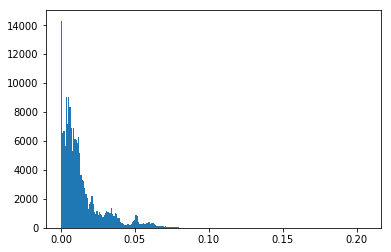

In [74]:
flag = 5
plt.bar((db_x[3.5][flag][1:] + db_x[3.5][flag][:-1]) * 0.5, \
        db[3.5][flag], \
       width=db_x[3.5][flag][1]-db_x[3.5][flag][0])

In [20]:
plt.bar(db[3.5][0], db[3.5])

[array([396.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

In [81]:
def linear_fit(x, y):
    pairs = [(y[i+1]-y[i]) / (x[i+1]-x[i]) for i in range(len(y)-1)][:][0]
    

0.9999999999999984

In [55]:
with open("/home/alex/TP/trans.pkl", "wb") as fb:
    pickle.dump(db, fb)

KeyError: 112

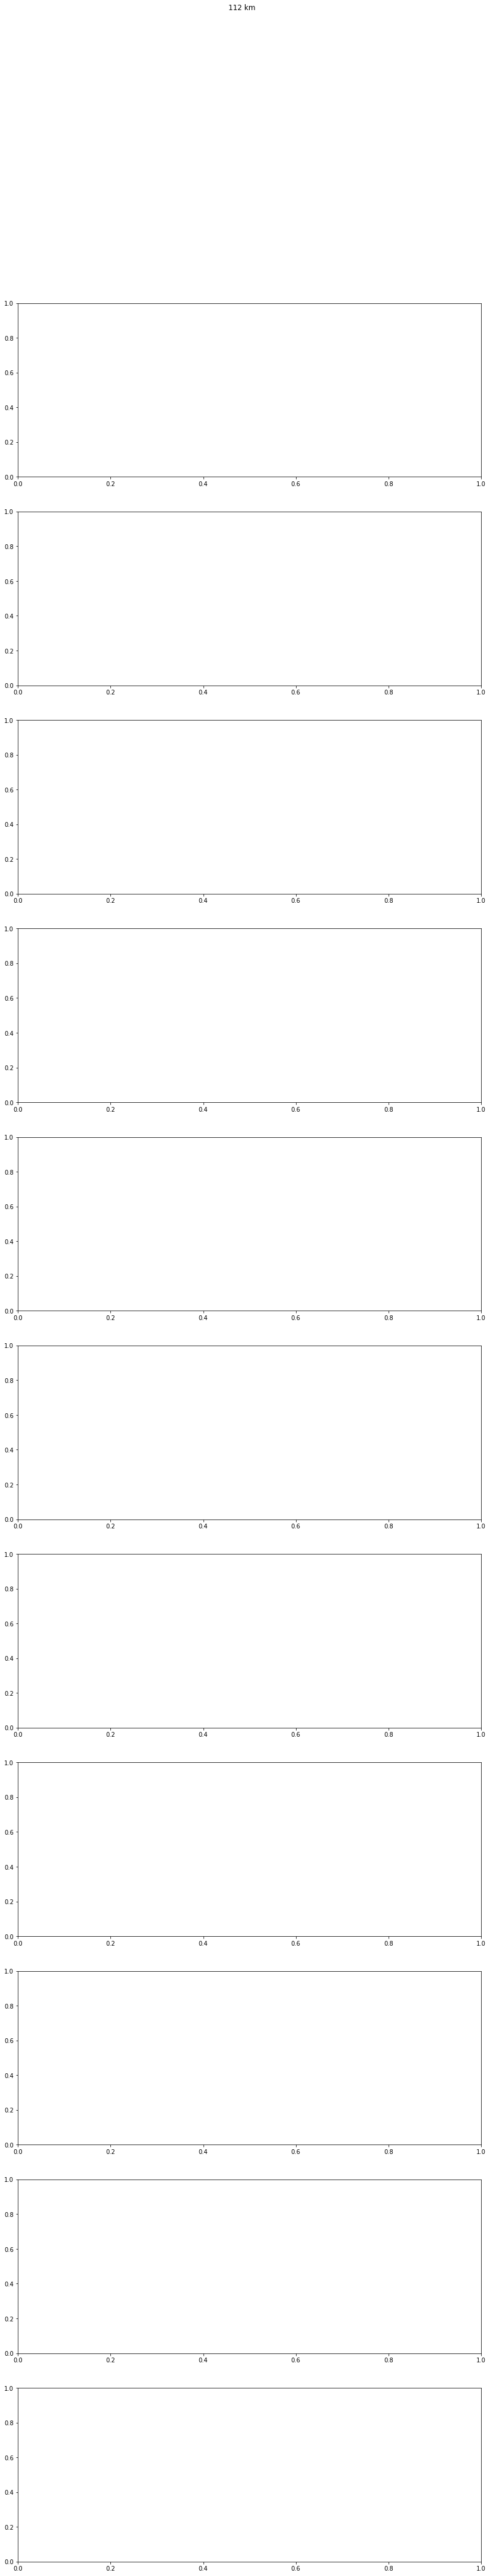

In [105]:
d = 112

fig, ax = plt.subplots(11, 1, figsize=(14, 70))
fig.suptitle(str(d) + " km")
for e0,elem in enumerate(storage_for_fit[d]):
    xfit, yfit = elem
    ax[e0].plot(xfit[:,0], yfit)
    ax[e0].scatter(xfit[:,0], yfit)
    
    l_reg = LinearRegression()
    l_reg.fit(xfit[int(len(xfit)*0.2):int(len(xfit)*0.7)], yfit[int(len(xfit)*0.2):int(len(xfit)*0.7)])
    ax[e0].plot(xfit[:,0], l_reg.coef_[0] * xfit[:,0] + l_reg.intercept_, c="r")
    ax[e0].grid()
    ax[e0].set_title(str(rads[e0] * dx) + " to " + str(rads[e0 + 1] * dx) + " cm")
    ax[e0].set_xlabel("Intensity")
    ax[e0].set_ylabel("Normed PDF")
    ax[e0].legend(["data for fit", "fit, -1/coef = " + str(-1/l_reg.coef_[0])])
    #1/0
plt.savefig("/home/alex/TP/"+str(d)+"km_linear_fit.pdf")

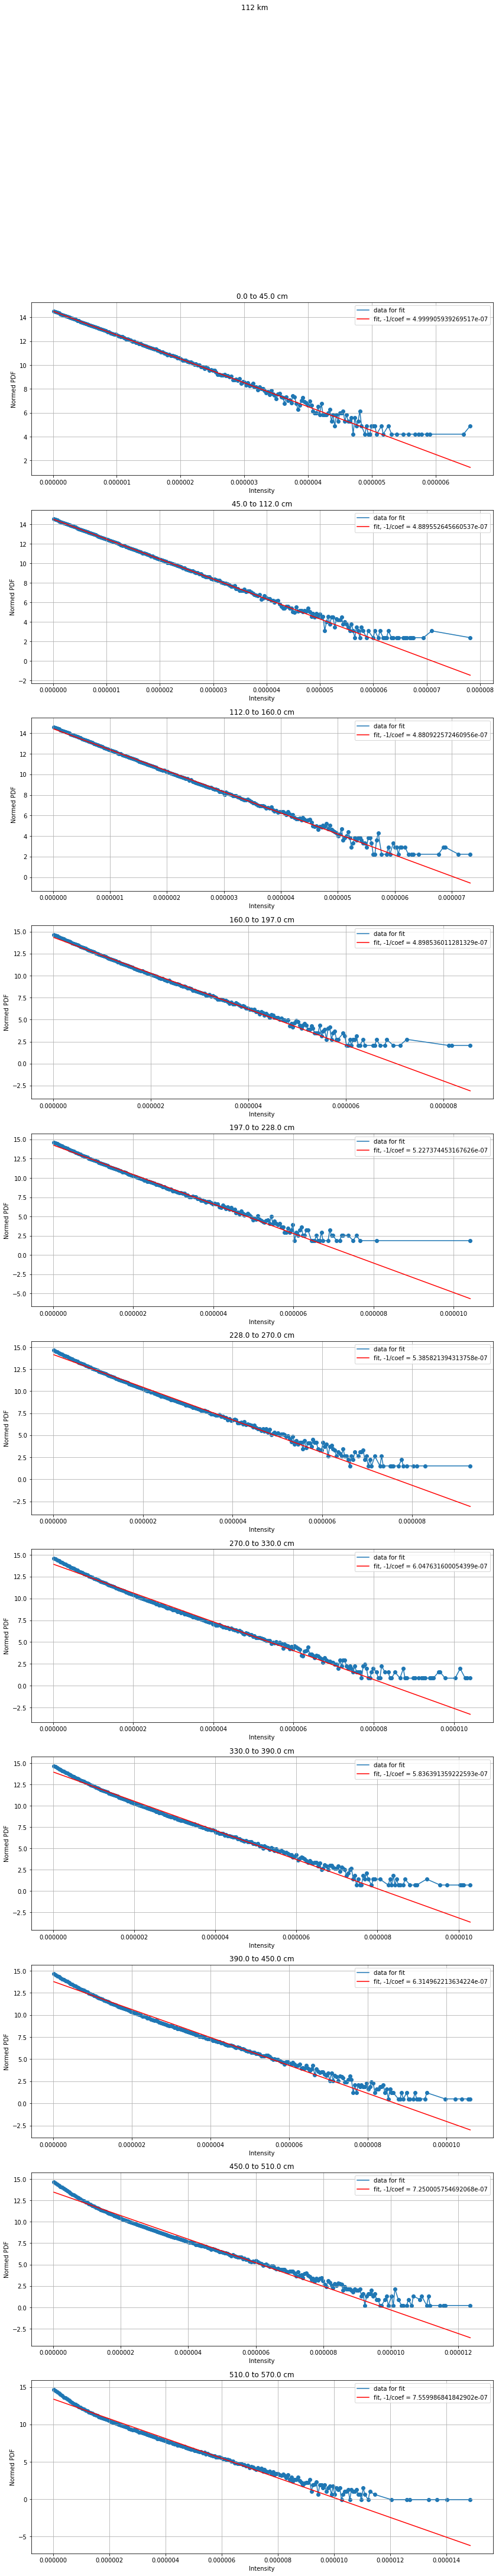

In [48]:
d = 112

fig, ax = plt.subplots(11, 1, figsize=(14, 70))
fig.suptitle(str(d) + " km")
for e0,elem in enumerate(storage_for_fit[d]):
    xfit, yfit = elem
    ax[e0].plot(xfit[:,0], yfit)
    ax[e0].scatter(xfit[:,0], yfit)
    
    l_reg = LinearRegression()
    l_reg.fit(xfit[int(len(xfit)*0.2):int(len(xfit)*0.7)], yfit[int(len(xfit)*0.2):int(len(xfit)*0.7)])
    ax[e0].plot(xfit[:,0], l_reg.coef_[0] * xfit[:,0] + l_reg.intercept_, c="r")
    ax[e0].grid()
    ax[e0].set_title(str(rads[e0] * dx) + " to " + str(rads[e0 + 1] * dx) + " cm")
    ax[e0].set_xlabel("Intensity")
    ax[e0].set_ylabel("Normed PDF")
    ax[e0].legend(["data for fit", "fit, -1/coef = " + str(-1/l_reg.coef_[0])])
    #1/0
plt.savefig("/home/alex/TP/"+str(d)+"km_linear_fit.pdf")

In [32]:
xfit.shape

(218, 1)

In [64]:
path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz"
for f in os.listdir(path_an):
    with open(os.path.join(path_an, f), "r") as f_curr:
        curr_data = f_curr.readlines()[1:]
        curr_data = [[float(s) for s in k.strip().split(" ")] \
                     for k in curr_data]
        

In [68]:
np.sort(temp_arr.ravel())[-100:]

array([0.18802736, 0.18802867, 0.18803488, 0.18803501, 0.18804267,
       0.18804805, 0.18804898, 0.18805984, 0.18806242, 0.18806563,
       0.18807156, 0.18808083, 0.18808178, 0.18808196, 0.18808581,
       0.18808656, 0.1880897 , 0.18809171, 0.18809676, 0.18812232,
       0.18812711, 0.18812985, 0.18813474, 0.18813564, 0.18814165,
       0.18814606, 0.18815137, 0.18815439, 0.18815696, 0.18816607,
       0.18819208, 0.18819438, 0.18820341, 0.18822151, 0.18824548,
       0.18827972, 0.18828325, 0.18830999, 0.18831123, 0.18831672,
       0.18834135, 0.18834386, 0.18834727, 0.18836443, 0.1883652 ,
       0.1883821 , 0.18843333, 0.18844234, 0.18844325, 0.18844351,
       0.18844358, 0.18845802, 0.18846308, 0.18846593, 0.18846628,
       0.188501  , 0.18850688, 0.18852486, 0.18852715, 0.18852777,
       0.18854234, 0.18857469, 0.18859127, 0.18859522, 0.1886009 ,
       0.18861032, 0.18861963, 0.18863287, 0.18864395, 0.18866792,
       0.18867219, 0.18867887, 0.18867998, 0.18868396, 0.18871

In [66]:
temp_arr = np.reshape(np.fromfile("/home/alex/TP/hse_data/"+\
                                  "psi_3500_1", \
                                dtype=np.float64), [8192, 8192])
#temp_arr = temp_arr[3072:-3072, 3072:-3072]
#temp_arr = temp_arr.ravel()
#plt.imshow(temp_arr)
#plt.hist(temp_arr.ravel()[temp_arr.ravel() < 0.1], bins=500)
#plt.show()

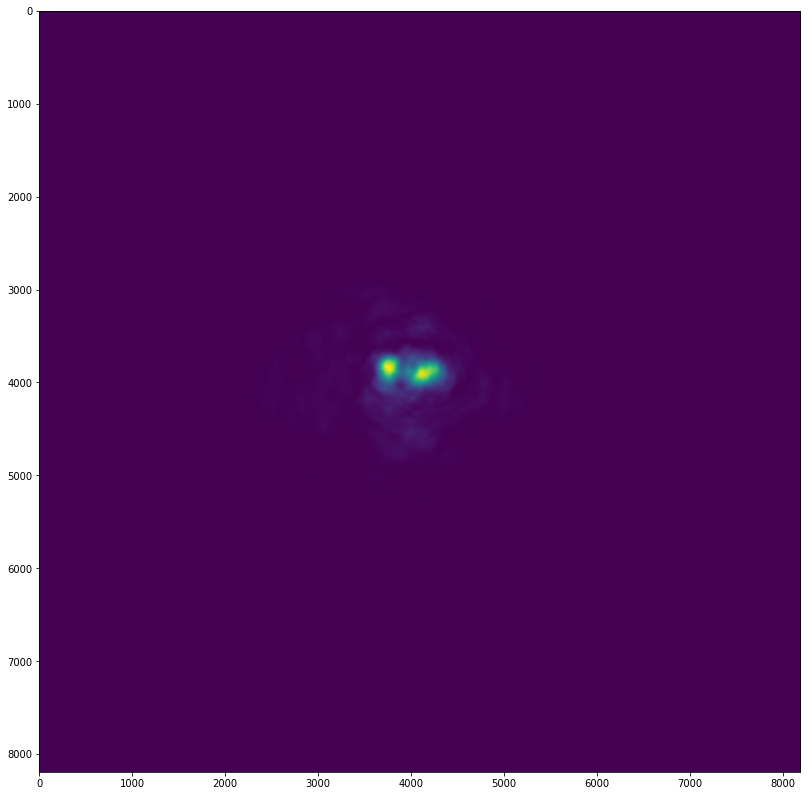

In [69]:
plt.figure(figsize=(14, 14))
plt.imshow(temp_arr)

In [13]:
with open("data_55_seeds.pkl", "wb") as fp:
    pickle.dump({"x": db_x, "intensity": db}, fp)

In [5]:
with open("data_55_seeds.pkl", "rb") as fp:
    data_curr = pickle.load(fp)

In [6]:
[[k,data_curr[k].keys()] for k in list(data_curr.keys())]

[['intensity', dict_keys([3.5, 28.0, 21.0, 14.0, 7.0])],
 ['x', dict_keys([3.5, 28.0, 21.0, 14.0, 7.0])]]

In [91]:
db_x[3.5][0][1:]-db_x[3.5][:-1]

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [92]:
len(db_x[3.5])

8

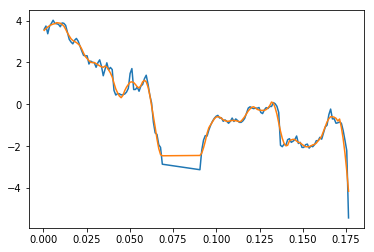

In [9]:
ind = 4
x_coord = (db_x[3.5][ind][1:] + db_x[3.5][ind][:-1]) / 2 
plt.plot(x_coord[db[3.5][ind] > 0], np.log(db[3.5][ind][db[3.5][ind] > 0]))
plt.plot(x, yhat)

In [8]:
from scipy.signal import savgol_filter
x, y = x_coord[db[3.5][ind] > 0], np.log(db[3.5][ind][db[3.5][ind] > 0])
yhat = savgol_filter(y, 11, 2)

In [7]:
def take_half(curr_dist):
    # path to analytical curves
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = np.stack([np.array([float(m) for m in s.strip().split(" ")]) \
            for s in data if len(s) > 0])

    # half-width
    data = data[data[:,1] > 0.5 * data[0,1], 0][-1]
    return data

def extract_an_vals(curr_dist, max_dist):
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    #path_an = "/home/abuzovkin/py_atm/scripts/an_data"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = [[float(m) for m in s.strip().split(" ")] for s in data if len(s) > 0]

    if np.max([n[0] for n in data]) < max_dist:
        data.append([max_dist + 1, 1e-10])
    interCurve = interp1d([n[0] for n in data], [n[1] for n in data], kind="linear")
    #try:
    #    return interCurve(curr_r)
    #except:
    #    return -1
    return interCurve

#dists = [3.5, 7.0, 14.0, 21.0, 28.0]
dists = [28, 56, 84, 112] #[3.5, 7., 14., 21., 28.] #[28, 56, 84, 112]
halfs = [take_half(d) for d in dists] #[127, 200, 350, 500]
db = {k: [] for k in dists}
db_x = {k: [] for k in dists}
db_size = {k: [] for k in dists}
db_std = {k: [] for k in dists}

storage_for_fit = {k: [] for k in dists}
num_max = 13
dx = 3900. / 36864

for d0,d in enumerate(dists):
    #if d != 28.:
    #    continue
    #path_28_f = "/home/alex/TP/hse_data/36864_small_mean"
    #path_28_f = "/home/alex/TP/hse_data/16384_mean"
    #path_28_f = "/home/alex/TP/hse_data/dists_f"
    #path_28_f = "/home/alex/TP/hse_data/36864_mean"
    path_28_f = "/home/alex/TP/hse_data/36864_eq_mean"

    key_files = [k for k in os.listdir(path_28_f) if \
                 str(k[:2])==str(int(d)) or \
                 str(k[:3])==str(int(d)) or \
                 str(k[:2])==str(d) or \
                 str(k[:3])==str(d) or \
                str(k[:1])==str(d) or \
                str(int(k[:1]))==str(d)]
    print(d, len(key_files))
    #print(d, len(key_files), "curr_files")
    
    #sch_local = 0
    for fp0,fp in enumerate(key_files):
        #if local == 200:
        #    break
        
        #local += 1
        with open(os.path.join(path_28_f, fp), "rb") as f28b:
            data_new = pickle.load(f28b)        
        #print(data_new)
        
        
        half_curr = take_half(d)
        rads = np.array([n * half_curr / 10 for n in \
                         range(num_max+1)])/dx
        #rads = rads[rads < 819.2]

        for p in range(num_max):
            x = np.array(data_new[0][p])
            y = np.array(data_new[1][p])# / calc_square(x, np.array(data_new[1][p]))
            st = np.array(data_new[2][p])

            if fp0 == 0:
                db[d].append(y)#-1/l_reg.coef_[0])
                db_x[d].append(x)
                db_std[d].append(st)
                db_size[d].append(data_new[3][p])
            else:
                db[d][p] += y#1/l_reg.coef_[0]
                db_std[d][p] += st
                db_size[d][p] += data_new[3][p]
                
    # norming procedure
    for p in range(num_max):
        #data_new[1])):
        #print(db_x[d][p].shape, db[d][p].shape)
        db[d][p] = db[d][p].astype(float)
        db_std[d][p] = db_std[d][p].astype(float)
        
        db[d][p] /= len(key_files)
        db_std[d][p] /= len(key_files)
        #ax[p].set_title(str(d)+" km, log")
        #ax[p].bar((db_x[d][p][1:]+db_x[d][p][:1])/2, np.log(db[d][p]), width=(db_x[d][p][1]-db_x[d][p][0])*0.9)
        #db[d][p] /= area(db_x[d][p], db[d][p])
    #plt.savefig("/home/alex/TP/all_"+str(d)+".pdf")
    print("==============", len(key_files), d)

28 248
============== 248 28
56 248
============== 248 56
84 248
============== 248 84
112 248
============== 248 112


In [7]:
db_size

{28: [8488410,
  25459560,
  42448560,
  59410680,
  76398840,
  93365160,
  110319720,
  127352400,
  144291000,
  161282520,
  178240440,
  195221040,
  212199960],
 56: [53050410,
  159155640,
  265259400,
  371351400,
  477433320,
  583589160,
  689598840,
  795784920,
  901869360,
  1007931120,
  1114051680,
  1220143680,
  1326284400],
 84: [255533641,
  766632900,
  1277678028,
  1788803412,
  2299860244,
  2810943828,
  3322006512,
  3833123536,
  4344177860,
  4855298228,
  5366353388,
  5877441988,
  6388525572],
 112: [586650669,
  1759936332,
  2933174552,
  4106464604,
  5279781408,
  6453080656,
  7626308844,
  8799552080,
  9972909848,
  11146156428,
  12319469888,
  13492688044,
  14665898676]}

In [621]:
db_x[3.5], db[3.5]

([array(0.6),
  array(1.8),
  array(3.),
  array(4.2),
  array(5.4),
  array(6.6),
  array(7.8),
  array(9.),
  array(10.2)],
 [array(0.01642183),
  array(0.01606298),
  array(0.01479663),
  array(0.01281254),
  array(0.01035605),
  array(0.0079905),
  array(0.00625076),
  array(0.0046066),
  array(0.0032027)])

In [8]:
with open("data_250_seeds_36_3f.pkl", "wb") as fp:
    pickle.dump({"x": db_x, "intensity": db, "size": db_size, "std": db_std}, fp)

#with open("data_300_seeds_8.pkl", "wb") as fp:
#    pickle.dump({"x": db_x, "intensity": db, "size": db_size}, fp)
#with open("prepared_data.pkl", "wb") as fp:
#    pickle.dump({"x": db_x, "intensity": db}, fp)
#with open("data_20_seeds_36.pkl", "wb") as fp:
#    pickle.dump({"x": db_x, "intensity": db}, fp)
#with open("data_add.pkl", "wb") as fp:
#    pickle.dump({"x": db_x, "intensity": db}, fp)

In [22]:
with open("data_100_seeds_4_3f.pkl", "wb") as fp:
    pickle.dump({"x": db_x, "y": db, "an": db_an}, fp)

In [118]:
path_28_f = "/home/alex/TP/hse_data/8192_mean"
db.keys(), type(list(db_x.keys())[0])

(dict_keys([56, 84, 28, 112]), int)

In [53]:
data_new[0]

array([ 12.,  36.,  60.,  84., 108., 132., 156., 180.])

In [501]:
coef_storage[28] = coef_storage_uni[28]
coef_x[28] = coef_x_uni[28]

In [577]:
coef_storage = {k: [] for k in [28, 56, 84, 112]}
coef_x = {k: [] for k in [28, 56, 84, 112]}

In [578]:
storage_all = []

In [582]:
###############################################################
# calculate iexp 
###############################################################
dist = 28
path_data = "/home/alex/TP/hse_data/iexp_calculated"
equal_bins = False

data_all = {}
data_x = {}
sch = 0
for f_elem in os.listdir(os.path.join(path_data, str(dist))):
    with open(os.path.join(path_data, str(dist), f_elem), "rb") as f:
        #data = pickle.load(f)
        data = pickle.load(f)
    
    for e0,elem in enumerate(data):
        if len(elem) > 0:
            if sch == 0:
                data_all[e0] = [elem[1]][:][0]
                data_x[e0] = [elem[0]][:][0]
            else:
                data_all[e0] += [elem[1]][:][0]
                data_x[e0] = [elem[0]][:][0]
            
    sch += 1
print(sch)

119


In [583]:
def calc_mse(arr1, arr2):
    return np.mean((arr1 - arr2) ** 2)

def linear_part(x, y):
    x = x[y > 0]
    y = y[y > 0]
    #print(x, y)
    local_ans = np.log(y[1:]) - np.log(y[:-1])
    local_ans /= (x[1:] - x[:-1])
    # first elem with derivative bigger than 0
    local_ans_big = local_ans > 0
    local_ans_big = [k0 for k0,k in enumerate(local_ans) \
                    if k > 0]
    # equal bins 
    #local_ans_big = [k for k in local_ans_big if k < len(x) / 2.]
    
    if len(local_ans_big) > 0:
        x = x[local_ans_big[-1] + 1:]
        y = y[local_ans_big[-1] + 1:]
    
    local_ans = np.log(y[1:]) - np.log(y[:-1])
    local_ans /= (x[1:] - x[:-1])

    suitable = local_ans < 0
    #print(suitable)
    suitable = np.concatenate([np.array([suitable[0]]), suitable])
    x = x[suitable]
    y = np.log(y[suitable])
    
    stor_coef, stor_intr = [], []
    for i in range(2, len(x)):
        lin_reg = LinearRegression()
        lin_reg.fit(x[:i].reshape(-1, 1), y[:i])
        #print(calc_mse(y[:i], lin_reg.coef_ * x[:i] + \
        #               lin_reg.intercept_), \
        #             -1. / lin_reg.coef_[0])
        #plt.plot(x[:i], y[:i])
        #plt.plot(x[:i], lin_reg.coef_[0] * x[:i] + \
        #               lin_reg.intercept_)
        #plt.legend(["gt", "fit"])
        #plt.show()
        #plt.close()
        stor_coef.append(lin_reg.coef_[0])
        stor_intr.append(lin_reg.intercept_)
        
    return [x, y, np.mean(stor_coef), np.mean(stor_intr)]

def extract_an_vals(curr_dist, max_dist):
    #path_an = "/home/abuzovkin/py_atm/scripts/an_data"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if f.find(str(int(curr_dist)))!=-1][0]
    #print(curr_dist, curr_file)
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = [[float(m) for m in s.strip().split(" ")] for s in data if len(s) > 0]

    if np.max([n[0] for n in data]) < max_dist:
        data.append([max_dist + 1, 1e-10])
    interCurve = interp1d([n[0] for n in data], [n[1] for n in data], kind="linear")
    #try:
    #    return interCurve(curr_r)
    #except:
    #    return -1
    return interCurve

def take_half(curr_dist):
    # path to analytical curves
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    print(curr_dist, curr_file)
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = np.stack([np.array([float(m) for m in s.strip().split(" ")]) \
            for s in data if len(s) > 0])

    # half-width
    #print(data[:,1])
    data = data[data[:,1] > 0.5 * data[0,1], 0][-1]
    return data


28 gammaRlist28p00.dat
120.0 ============
28


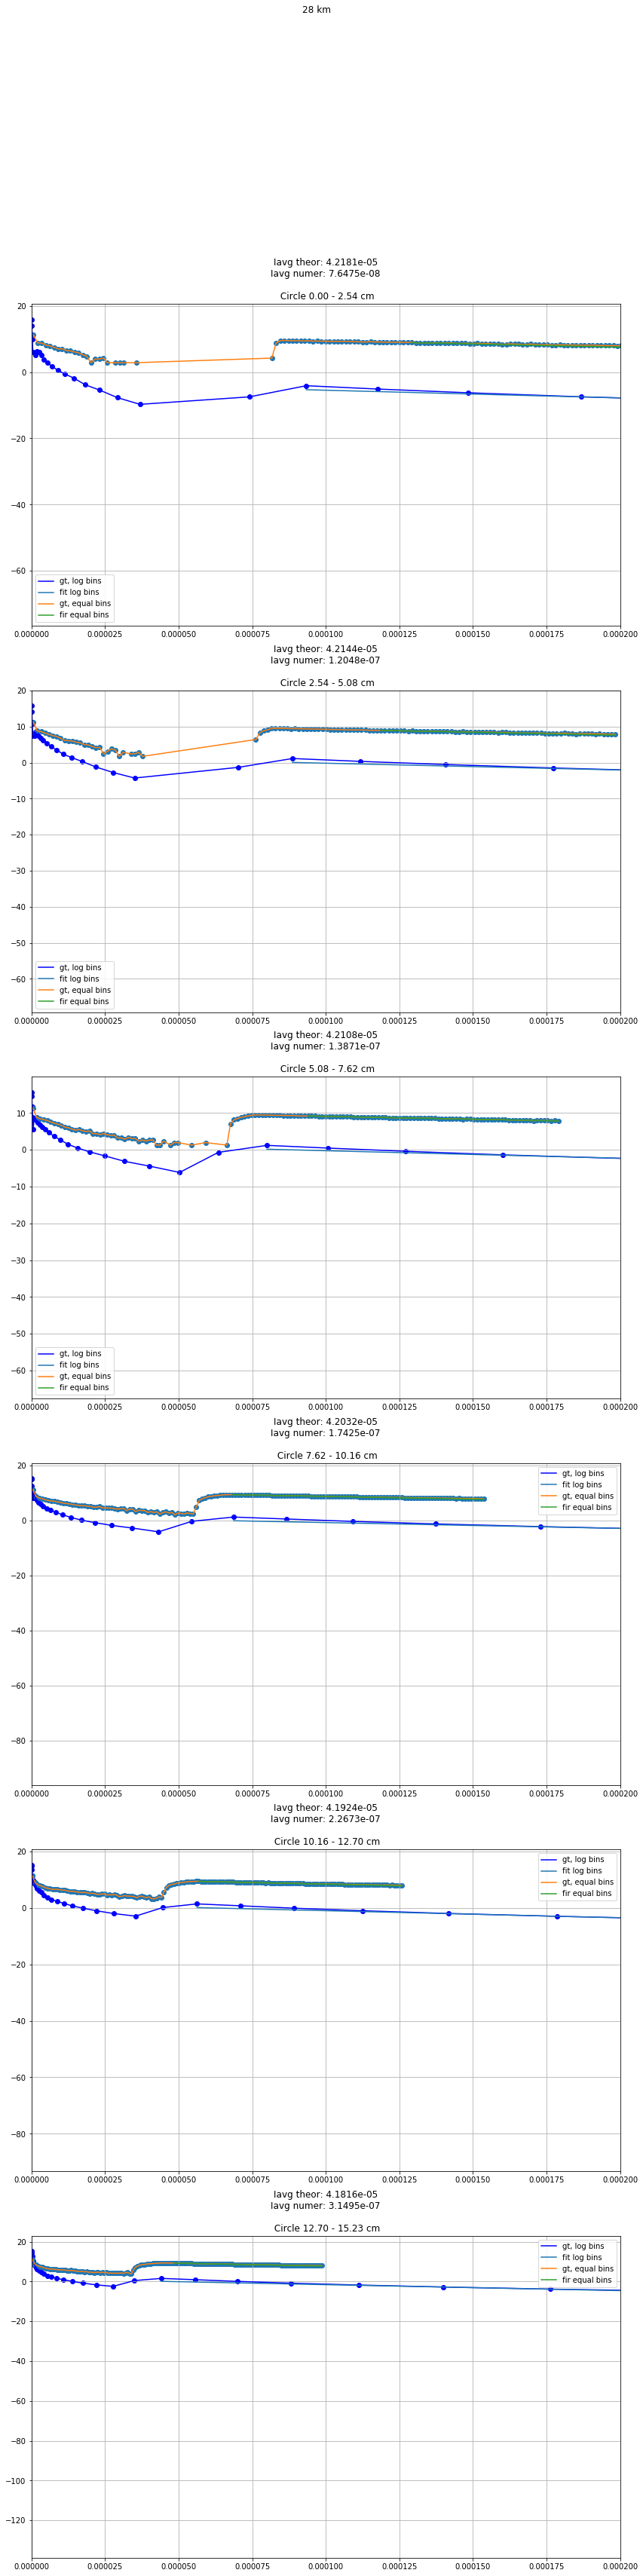

In [593]:
#################################################
# norming stage
#################################################
def normalizing_log(x, y):
    return y / np.sum(y) / (x[1:] - x[:-1])

def normalizing(x, y):
    return y / np.sum(y) / (x[1:] - x[:-1])

interCurve = extract_an_vals(dist, 2000)
half_rad = take_half(dist)
print(half_rad, "============")
dx = 3900 / 36864.
half_rad = np.array([n * half_rad / 5 for n in range(7)]) * dx
numbins = 50
sbplts = [611, 612, 613, 614, 615, 616]

#fig, ax = plt.subplots(6, 2, figsize=(14, 55))
plt.figure(figsize=(14, 55))
plt.suptitle(str(dist) + " km")
print(dist)
for circ in range(len(half_rad)-1):
    Iavg = interCurve((half_rad[circ] + half_rad[circ + 1]) / 2)
    binsize0 = Iavg * 1e-2
    lastedge = Iavg * 1e+3
    c = np.log(1 + lastedge / binsize0) / numbins
    binedges = (np.exp(c * np.arange(numbins + 1)) - 1) * binsize0
    
    binedges = binedges.astype(np.float32)

    # for equal bins
    #binedges = np.array([Iavg * n / 30. for n in range(151)])
    Iavg_n = np.sum(0.5 * (binedges[1:] + binedges[:-1]) * \
                    data_all[circ]) / np.sum(data_all[circ])

    data_all[circ] = data_all[circ].astype(np.float32)
    ################################ log normalizing
    data_all[circ] = normalizing(binedges, data_all[circ])

    #binedges = np.array([Iavg * n / 250. for n in range(251)])
    #data_all[circ] /= np.sum(data_all[circ] * \
    #                    (binedges[1:] - binedges[:-1]))
    ################################ log normalizing

    #print(len(binedges), len(data_all[circ]))             
    x_lin, y_lin, k, b = linear_part(data_x[circ], data_all[circ])
    
    gt_x = [data_x[circ]][:][0]
    gt_y = [data_all[circ]][:][0]
    gt_x = gt_x[gt_y > 0]
    gt_y = gt_y[gt_y > 0]
    
    plt.subplot(sbplts[circ])
    #plt.plot(gt_x, np.log(gt_y), c='b')
    #plt.scatter(gt_x, np.log(gt_y), c='b')
    plt.plot(data_x[circ][data_all[circ]!=0], np.log(data_all[circ][data_all[circ]!=0]), c='b')
    plt.scatter(data_x[circ][data_all[circ]!=0], np.log(data_all[circ][data_all[circ]!=0]), c='b')
    plt.plot(x_lin, x_lin * k + b)
    
    plt.plot(storage_all[circ][0], storage_all[circ][1])
    plt.scatter(storage_all[circ][0], storage_all[circ][1])
    plt.plot(storage_all[circ][2], storage_all[circ][3])
    
    #storage_all.append([gt_x, np.log(gt_y), x_lin, x_lin * k + b]);
    
    coef_storage[dist].append(-1. / k)
    coef_x[dist].append((half_rad[circ] + half_rad[circ + 1]) / 2)
    #coef_storage_uni[dist].append(-1. / k)
    #coef_x_uni[dist].append((half_rad[circ] + half_rad[circ + 1]) / 2)
    #plt.title("Circle " + str(half_rad[circ]) + " - " + \
    #         str(half_rad[circ + 1]))
    plt.title("Iavg theor: " + str("{:.4e}".format(Iavg)) + "\n"+\
              "Iavg numer: " + str("{:.4e}".format(Iavg_n)) + "\n"\
              +"\n Circle " + str("{:.2f}".format(half_rad[circ])) + \
             " - " + str("{:.2f}".format(half_rad[circ + 1])) + " cm")
    plt.legend(["gt, log bins", "fit log bins", \
               "gt, equal bins", "fir equal bins"])
    plt.grid()
    plt.xlim(0, 0.0002)
plt.savefig(str(dist)+"_km_comparison_small_axis.pdf")
#print("======================END=======================")

In [ ]:
# one code for combining

In [239]:
x_lin, data_x[circ]#y_lin

(array([0.00000000e+00, 1.63056507e-07, 3.19683062e-07, 5.13973800e-07,
        3.31220085e-06, 4.27919489e-06, 5.49652861e-06, 7.02903149e-06,
        8.95831615e-06, 1.13871249e-05, 1.44448012e-05, 1.82941780e-05,
        2.31402493e-05, 2.92410865e-05, 3.69215820e-05, 1.17668504e-04,
        1.48245113e-04, 1.86738790e-04, 2.35199467e-04, 2.96207856e-04,
        3.73012883e-04, 4.69704702e-04, 5.91432514e-04, 7.44678780e-04,
        9.37604437e-04, 1.18048350e-03, 1.48625018e-03, 1.87118770e-03,
        2.35579543e-03]),
 array([0.00000000e+00, 1.63056507e-07, 3.19683062e-07, 5.13973800e-07,
        7.57579106e-07, 1.06378699e-06, 1.44901392e-06, 1.93382080e-06,
        2.54404715e-06, 3.31220085e-06, 4.27919489e-06, 5.49652861e-06,
        7.02903149e-06, 8.95831615e-06, 1.13871249e-05, 1.44448012e-05,
        1.82941780e-05, 2.31402493e-05, 2.92410865e-05, 3.69215820e-05,
        4.65907511e-05, 5.87635131e-05, 7.40881131e-05, 9.33806435e-05,
        1.17668504e-04, 1.48245113e-04

In [195]:
data_x[0] = data_x[0][data_all[0] > 0]
data_all[0] = data_all[0][data_all[0] > 0]
local_ans = (np.log(data_all[0][1:]) - np.log(data_all[0][:-1])) / \
                (data_x[0][1:] - data_x[0][:-1])

In [198]:
local_ans[local_ans < 0]

array([-30709.44820061, -55387.21466426, -63958.7036825 , -69703.07391475,
       -66637.39420381, -65850.51990057, -62850.9770097 , -57268.59103048,
       -53976.96989311, -51190.0568735 , -51059.89326328, -45779.35140239,
       -48791.63610478])

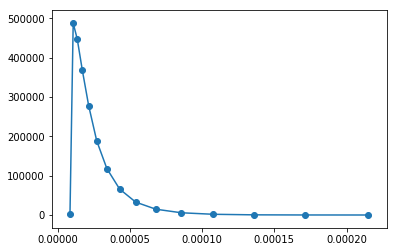

In [199]:
plt.plot(data_x[0], data_all[0])
plt.scatter(data_x[0], data_all[0])

0.0 1.8054708222135217e-05


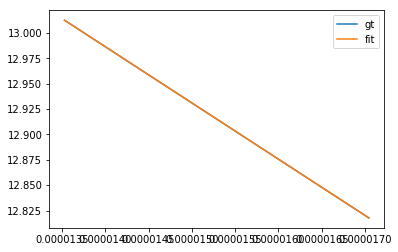

6.240307587527237e-05 1.6576848235858247e-05


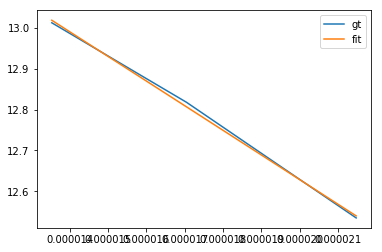

0.0002369172810976662 1.552908966960402e-05


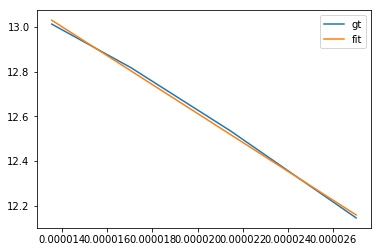

0.00024141554133565724 1.5233442974731628e-05


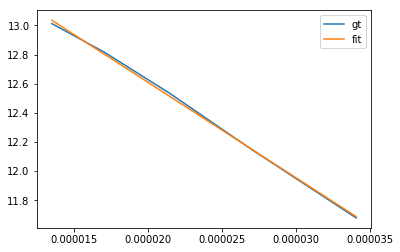

0.000208195143689495 1.5164412153672335e-05


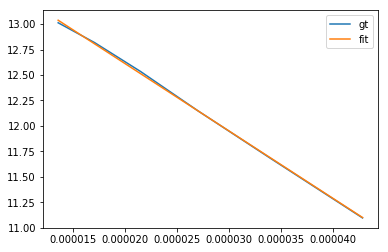

0.00023242710747236535 1.5296996965698857e-05


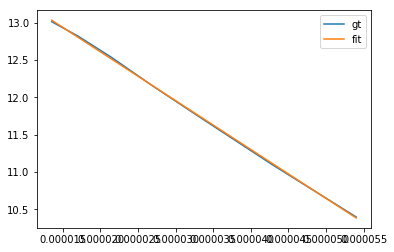

0.0010746247886039778 1.5691892598464874e-05


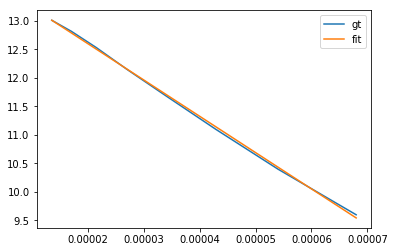

0.0036320283886921217 1.6232213925506666e-05


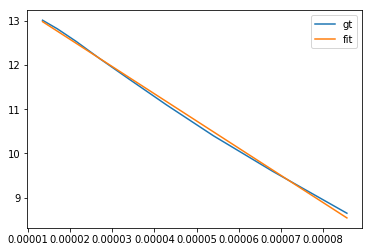

0.00881395214962112 1.685873679928008e-05


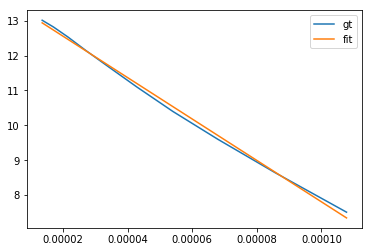

0.015183902483766899 1.744106903174158e-05


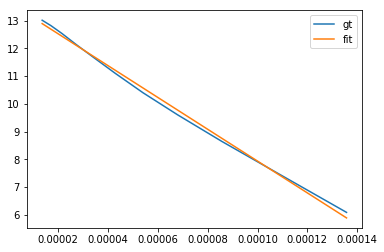

0.029822040215653545 1.815940401311307e-05


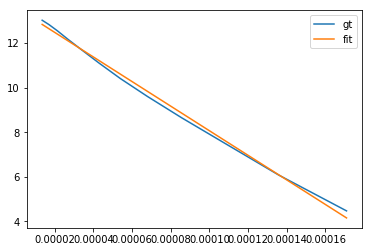

In [218]:
def calc_mse(arr1, arr2):
    return np.mean((arr1 - arr2) ** 2)

def linear_part(x, y):
    x = x[y > 0]
    y = y[y > 0]
    local_ans = np.log(y[1:]) - np.log(y[:-1])
    local_ans /= (x[1:] - x[:-1])
    
    suitable = local_ans < 0
    suitable = np.concatenate([np.array([suitable[0]]), suitable])
    x = x[suitable]
    y = np.log(y[suitable])
    
    stor_coef, stor_intr = [], []
    for i in range(2, len(x)):
        lin_reg = LinearRegression()
        lin_reg.fit(x[:i].reshape(-1, 1), y[:i])
        print(calc_mse(y[:i], lin_reg.coef_ * x[:i] + \
                       lin_reg.intercept_), \
                     -1. / lin_reg.coef_[0])
        plt.plot(x[:i], y[:i])
        plt.plot(x[:i], lin_reg.coef_[0] * x[:i] + \
                       lin_reg.intercept_)
        plt.legend(["gt", "fit"])
        plt.show()
        plt.close()
        stor_coef.append(lin_reg.coef_[0])
        stor_intr.append(lin_reg.intercept_)
        
    return [x, y, np.mean(stor_coef), np.mean(stor_intr)]

x, y, k, b = linear_part(data_x[0], data_all[0])

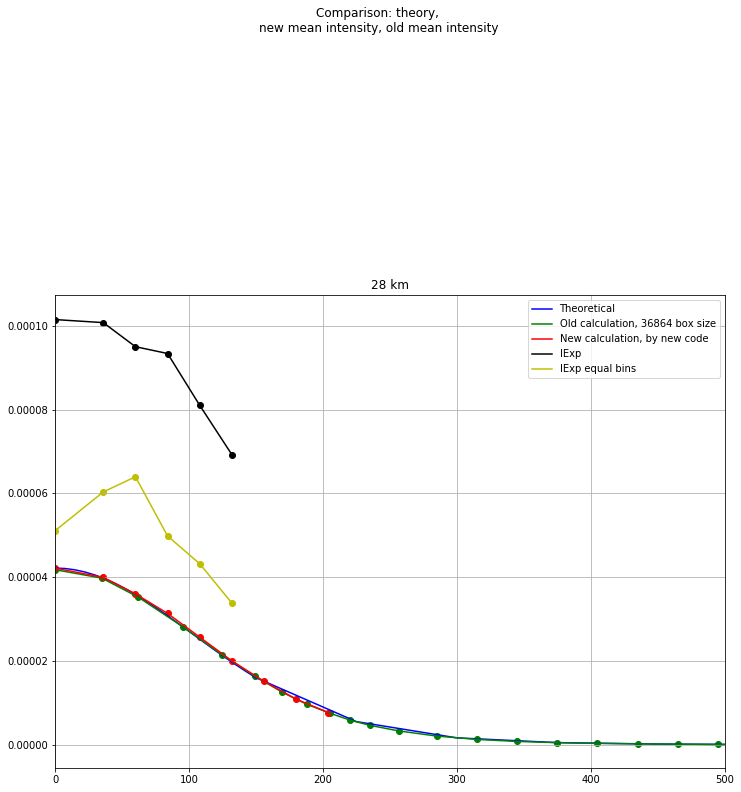

In [589]:
# path for mean 120 seeds, old counting
d = 28
plt.figure(figsize=(12, 40))
sbplts = [411, 412, 413, 414]
path_conv = "/home/alex/TP/hse_data/convergence/"
path_aux = "/home/alex/TP/octave_an/data/old/an_data"

plt.suptitle("Comparison: theory, \n"+ \
             "new mean intensity, old mean intensity")
for d0,d in enumerate([28, 56, 84, 112]):
    if d0 > 0:
        continue
    # old calculation
    with open(os.path.join(path_conv, str(d)), "rb") as f_conv:
        ens120 = pickle.load(f_conv)
    ens120[0][0] = 0

    # new calculation
    with open("prepared_data.pkl", "rb") as fp:
        data_num = pickle.load(fp)
    data_num["x"][d][0] = 0.

    # theor data
    with open(os.path.join(path_aux, \
                "gammaRlist"+str(d)+"p00.dat"), "r") as f:
        data_theor = f.readlines()[1:]

    data_theor = [[float(s) for s in k.strip().split(" ")] \
                  for k in data_theor]
    th_x, th_y = np.array([s[0] for s in data_theor]), \
                        np.array([s[1] for s in data_theor])

    plt.subplot(sbplts[d0])
    plt.plot(th_x, th_y, c='b')
    #plt.scatter(th_x, th_y, c='b')

    plt.plot(ens120[0]*dx, ens120[1], c='g')
    plt.scatter(ens120[0]*dx, ens120[1], c='g')

    plt.plot(data_num['x'][d], data_num['intensity'][d], c='r')
    plt.scatter(data_num['x'][d], data_num['intensity'][d], c='r')

    coef_x[d][0] = 0.
    plt.plot(np.array(coef_x[d])/dx, coef_storage[d], c='k')
    plt.scatter(np.array(coef_x[d])/dx, coef_storage[d], c='k')
    
    if d0 == 0:
        plt.xlim(0, 500)
    if d0 == 0:
        plt.plot(np.array(coef_x_uni[d])/dx, coef_storage_uni[d], c="y")
        plt.scatter(np.array(coef_x_uni[d])/dx, coef_storage_uni[d], c="y")
        
    plt.title(str(d) + " km")
    if d0 == 0:
        plt.legend(["Theoretical", "Old calculation, 36864 box size", \
               "New calculation, by new code", "IExp", "IExp equal bins"])        
    else:
        plt.legend(["Theoretical", "Old calculation, 36864 box size", \
               "New calculation, by new code", "IExp"])
    plt.grid()
plt.savefig("/home/alex/TP/comparison_approaches.pdf")

In [495]:
coef_x_uni, coef_storage_uni

({28: [], 56: [], 84: [], 112: []}, {28: [], 56: [], 84: [], 112: []})

In [588]:
coef_x_uni[28][0] = 0.

In [594]:
data_all

{0: array([7.7429435e+06, 1.0914716e+06, 1.9005693e+04, 4.4507632e+02,
        0.0000000e+00, 0.0000000e+00, 1.8721568e+02, 5.4408258e+02,
        4.0650156e+02, 1.5887782e+02, 4.6320938e+01, 1.5819654e+01,
        5.8507242e+00, 1.7061142e+00, 5.5518389e-01, 1.6224013e-01,
        2.1529641e-02, 4.4718729e-03, 4.4507097e-04, 5.9061978e-05,
        0.0000000e+00, 0.0000000e+00, 5.6643516e-04, 1.6344430e-02,
        5.9758592e-03, 1.9473383e-03, 5.7923549e-04, 1.6627784e-04,
        4.3972672e-05, 1.1298462e-05, 2.6734010e-06, 5.7942151e-07,
        1.2670156e-07, 2.1214781e-08, 3.0121250e-09, 5.6430444e-10,
        9.3605609e-11, 7.4529983e-12, 2.9670936e-12, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32),
 1: array([7.0676740e+06, 1.5428154e+06, 5.1875523e+04, 1.8641035e+03,
        0.0000000e+00, 1.7743861e+03, 4.6070659e+03, 2.

In [31]:
""" Convergence per 20 seeds """
def take_half(curr_dist):
    # path to analytical curves
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = np.stack([np.array([float(m) for m in s.strip().split(" ")]) \
            for s in data if len(s) > 0])

    # half-width
    data = data[data[:,1] > 0.5 * data[0,1], 0][-1]
    return data

def extract_an_vals(curr_dist, max_dist):
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    #path_an = "/home/abuzovkin/py_atm/scripts/an_data"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = [[float(m) for m in s.strip().split(" ")] for s in data if len(s) > 0]

    if np.max([n[0] for n in data]) < max_dist:
        data.append([max_dist + 1, 1e-10])
    interCurve = interp1d([n[0] for n in data], [n[1] for n in data], kind="linear")
    #try:
    #    return interCurve(curr_r)
    #except:
    #    return -1
    return interCurve

#dists = [3.5, 7.0, 14.0, 21.0, 28.0]
dists = [28, 56, 84, 112] #[3.5, 7., 14., 21., 28.] #[28, 56, 84, 112]
halfs = [take_half(d) for d in dists]
db = {k: [] for k in dists}
db_x = {k: [] for k in dists}
db_size = {k: [] for k in dists}
db_std = {k: [] for k in dists}

storage_for_fit = {k: [] for k in dists}
num_max = 12
dx = 3900. / 36864

conv_per_20 = {d: [] for d in dists}
n_cut = 20
#conv_per_50 = {d: [] for d in dists}

for d0,d in enumerate(dists):
    #if d != 28.:
    #    continue
    #path_28_f = "/home/alex/TP/hse_data/36864_small_mean"
    #path_28_f = "/home/alex/TP/hse_data/16384_mean"
    #path_28_f = "/home/alex/TP/hse_data/dists_f"
    #path_28_f = "/home/alex/TP/hse_data/36864_mean"
    path_28_f = "/home/alex/TP/hse_data/36864_eq_mean"

    key_files = [k for k in os.listdir(path_28_f) if k.find(str(int(d))+"_")!=-1]
    #key_files = [k for k in os.listdir(path_28_f) if \
    #             str(k[:2])==str(int(d)) or \
    #             str(k[:3])==str(int(d)) or \
    #             str(k[:2])==str(d) or \
    #             str(k[:3])==str(d) or \
    #            str(k[:1])==str(d) or \
    #            str(int(k[:1]))==str(d)]
    print(d, len(key_files))
    #print(d, len(key_files), "curr_files")
    
    local = 0
    for fp0,fp in enumerate(key_files):
        if local == 248:
            break
        
        local += 1
        with open(os.path.join(path_28_f, fp), "rb") as f28b:
            data_new = pickle.load(f28b)        
        #print(data_new)
        
        
        half_curr = take_half(d)
        rads = np.array([n * half_curr / 10 for n in \
                         range(num_max+1)])/dx
        #rads = rads[rads < 819.2]

        for p in range(num_max):
            x = np.array(data_new[0][p])
            y = np.array(data_new[1][p])# / calc_square(x, np.array(data_new[1][p]))
            st = np.array(data_new[2][p])

            if (local - 1) % n_cut == 0 or fp0 == 0:
                #fp0 == 0:
                db[d].append(y)#-1/l_reg.coef_[0])
                db_x[d].append(x)
                db_std[d].append(st)
                db_size[d].append(data_new[3][p])
            else:
                db[d][p] += y#1/l_reg.coef_[0]
                db_std[d][p] += st
                db_size[d][p] += data_new[3][p]

        if local % n_cut != 0:
            continue
        # norming procedure
        for p in range(num_max):
            #data_new[1])):
            #print(db_x[d][p].shape, db[d][p].shape)
            db[d][p] = db[d][p].astype(float)
            db_std[d][p] = db_std[d][p].astype(float)

            db[d][p] /= n_cut#len(key_files)
            db_std[d][p] /= n_cut#len(key_files)
        conv_per_20[d].append([[np.array(db_x[d]), np.array(db[d])]][:][0])
        db = {k: [] for k in dists}
        db_x = {k: [] for k in dists}
        db_size = {k: [] for k in dists}
        db_std = {k: [] for k in dists}
        
            #ax[p].set_title(str(d)+" km, log")
            #ax[p].bar((db_x[d][p][1:]+db_x[d][p][:1])/2, np.log(db[d][p]), width=(db_x[d][p][1]-db_x[d][p][0])*0.9)
            #db[d][p] /= area(db_x[d][p], db[d][p])
    #plt.savefig("/home/alex/TP/all_"+str(d)+".pdf")
    print("==============", len(key_files), d)

28 248
============== 248 28
56 248
============== 248 56
84 248
============== 248 84
112 248
============== 248 112


In [34]:
with open("/home/alex/TP/comet_data/conv_20_60.pkl", "wb") as f:
    pickle.dump({20: conv_per_20, 60: conv_per_60}, f)

In [33]:
len(conv_per_20[28])

12

In [35]:
def extract_an_vals(curr_dist, max_dist):
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    #path_an = "/home/abuzovkin/py_atm/scripts/an_data"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = [[float(m) for m in s.strip().split(" ")] for s in data if len(s) > 0]

    if np.max([n[0] for n in data]) < max_dist:
        data.append([max_dist + 1, 1e-10])
    interCurve = interp1d([n[0] for n in data], [n[1] for n in data], kind="linear")
    return interCurve

def take_half(curr_dist):
    # path to analytical curves
    #path_an = "/home/alex/Downloads/refwdpdfofintensityatshorterz/"
    path_an = "/home/alex/TP/octave_an/data/old/an_data"
    curr_file = [f for f in os.listdir(path_an) if \
                 f.find(str(int(curr_dist)))!=-1][0]
    with open(os.path.join(path_an, curr_file), "r") as f:
        data = f.readlines()[1:]
    data = np.stack([np.array([float(m) for m in s.strip().split(" ")]) \
            for s in data if len(s) > 0])

    # half-width
    data = data[data[:,1] > 0.5 * data[0,1], 0][-1]
    return data

In [116]:
############################################### IEXP
path_iexp = "/home/alex/TP/hse_data/iexp_calculated"
dist = [28, 56, 84]

def normalizing(x, y):
    return y / np.sum(y) / (x[1:] - x[:-1])

dnum = 56
numbins = 50
xdata = {k: [[]]*6 for k in dist}
ydata = {k: [[]]*6 for k in dist}
for f0,fname in enumerate(os.listdir(os.path.join(path_iexp, str(dnum)))):
    #print(f0)
    if fname.find("_11.pkl") != -1:
        continue
    with open(os.path.join(path_iexp, str(dnum), fname), "rb") as f:
        data = pickle.load(f)
    if f0 == 0:
        interCurve = extract_an_vals(dnum, 2000)
        half_rad = take_half(dnum)
        half_curr = take_half(dnum)
        half_rad = np.array([n * half_curr / 5 for n in range(7)])
        for circ in range(len(half_rad) - 1):
            ######################
            Iavg = interCurve((half_rad[circ] + half_rad[circ+1]) / 2)
            print(Iavg)
            binsize0 = Iavg * 1e-2
            lastedge = Iavg * 1e+3
            c = np.log(1 + lastedge / binsize0) / numbins
            binedges = (np.exp(c * np.arange(numbins + 1)) - 1) * binsize0
            #####################
            
            #print(circ)
            xdata[dnum][circ] = [binedges][:][0] / Iavg#data[0][0]
            ydata[dnum][circ] = [data[circ][1]][:][0]# / Iavg
        #print(xdata[dnum].shape, ydata[str(dnum)].shape)
        #1/0
    else:
        try:
            for circ in range(len(half_rad) - 1):
                #Iavg = interCurve((half_rad[circ] + half_rad[circ+1]) / 2)
                ydata[dnum][circ] += ([data[circ][1]][:][0])# / Iavg)
            #print(f0, len(data), np.sum(data[0][1][:10]), fname)
        except:
            print("==========================================")
            print(f0, fname, len(data))
            #print(data)
            #1/0

    #ydata[dnum][circ] = ydata[dnum][circ].astype(int)
    #ydata[dnum][circ] = ydata[dnum][circ].astype(float)

for circ in range(len(half_rad) - 1):
    # cut data
    nonzero = list(np.where(ydata[dnum][circ]!=0)[0][1:])
    ydata[dnum][circ] = [ydata[dnum][circ][nonzero]][:][0]
    nonzero.append(nonzero[-1] + 1)
    xdata[dnum][circ] = [xdata[dnum][circ][nonzero]][:][0]

    ydata[dnum][circ] = normalizing([xdata[dnum][circ]][:][0], [ydata[dnum][circ]][:][0].astype(float))
    

4.817553046688068e-06
4.639718059670807e-06
4.3053514823006665e-06
3.842198055966688e-06
3.3240286103168383e-06
2.786815903039287e-06


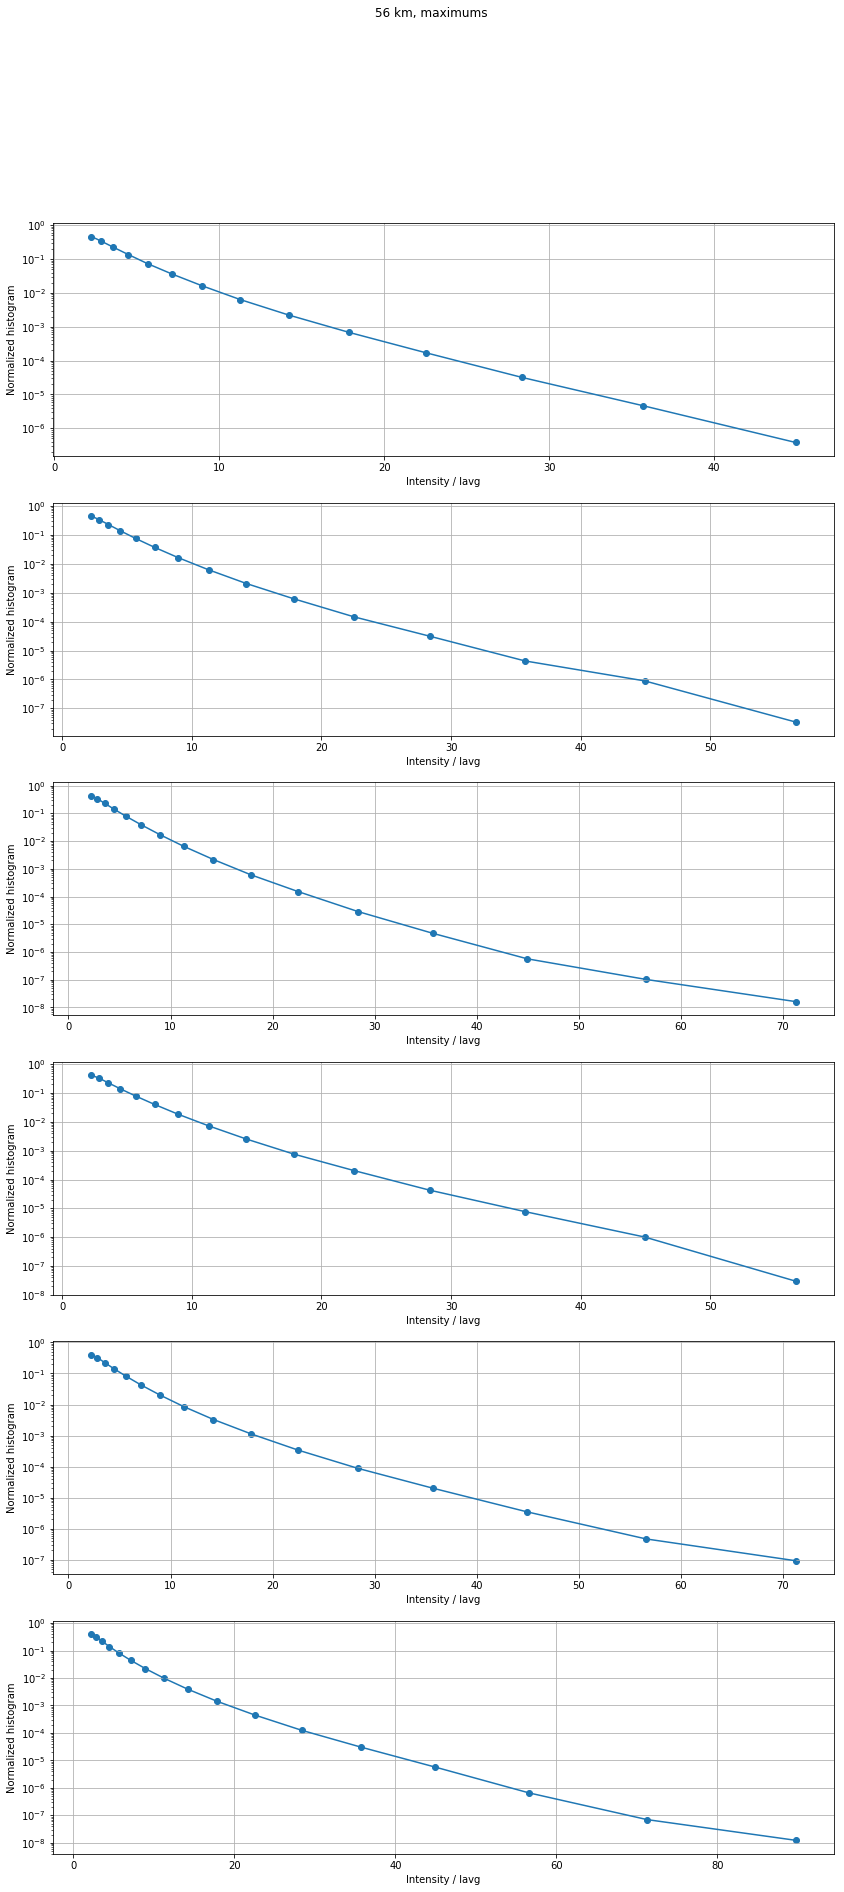

In [119]:
sbplts = [611, 612, 613, 614, 615, 616]
dnum = 56
plt.figure(figsize=(14,30))
for i in range(len(sbplts)):
    plt.suptitle("56 km, maximums")
    plt.subplot(sbplts[i])
    #plt.xscale("log")
    plt.yscale("log")
    plt.plot(0.5*(xdata[dnum][i][1:]+xdata[dnum][i][:-1]), ydata[dnum][i])
    plt.scatter(0.5*(xdata[dnum][i][1:]+xdata[dnum][i][:-1]), ydata[dnum][i])
    plt.ylabel("Normalized histogram")
    plt.xlabel("Intensity / Iavg")
    plt.grid("on")